# SETUP

In [1]:
import os
import json
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from stable_baselines3 import TD3 as sb3TD3
import pickle

In [2]:
train_path = 'local/runs/example_run/'
binvox_path = train_path + 'map_voxels.binvox'
model_path = train_path + 'model.zip'

train_log_path = train_path + 'log.txt'
train_configuration_path = train_path + 'configuration.json'
train_states_path = train_path + 'states/'

test_path = train_path + 'test/'
test_log_path = test_path + 'log.txt'
test_configuration_path = test_path + 'configuration.json'
test_states_path = test_path + 'states/'

# Configuration

In [3]:
train_configuration = json.load(open(train_configuration_path, 'r'))
test_configuration = json.load(open(test_configuration_path, 'r'))

# Actor model

In [4]:
mdl = sb3TD3.load(model_path)
mdl.actor.mu

Sequential(
  (0): Linear(in_features=50, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=3, bias=True)
  (5): Tanh()
)

# read states

In [10]:
# read evaluations from each instance
# each instance is a sub folder from parent with which this eval notebook is in
instances = [
    train_path + 'states',
    test_path + 'states',
    ]
all_evaluations = {}
for instance in instances:
    all_evaluations[instance] = read_evaluations(instance + '/')

# path accuracy

total accuracy = 15.43%


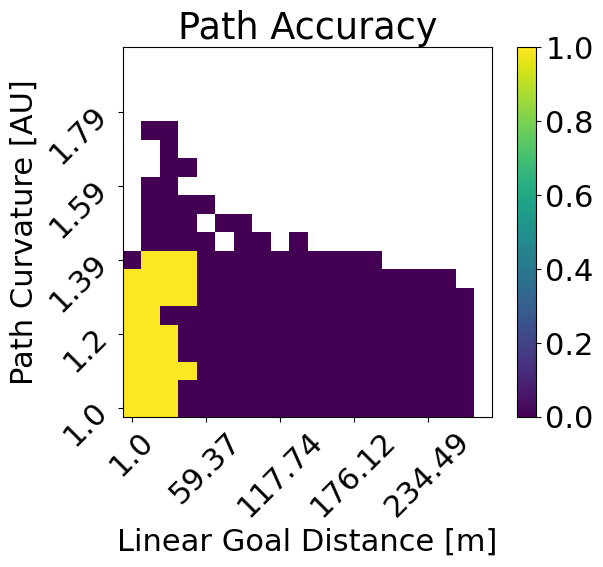

In [14]:
acc_instances = [
    #train_path + 'train_states',
    test_path + 'states',
]
goals = []
for instance in acc_instances:
    for set_num, episodes in enumerate(all_evaluations[instance]):
        for episode, states in enumerate(episodes):
            final_step = states[-1]
            goals.append(final_step['reached_goal'])
print(f'total accuracy = {np.round(100*np.mean(goals),2)}%')

# check against astar paths
path_idxs = pickle.load(open(test_path+'_static_path_idxs.p', 'rb'))
astar_paths = pickle.load(open('astar_paths/Blocks_2d_test.p', 'rb'))
linearity_bounds = astar_paths['linearity_bounds']
nonlinearity_bounds = astar_paths['nonlinearity_bounds']
goal_map = np.zeros([len(linearity_bounds), len(nonlinearity_bounds)]).astype(float)
total_map = np.zeros([len(linearity_bounds), len(nonlinearity_bounds)]).astype(float)
def get_bin(linearity, nonlinearity):
    for i in range(len(linearity_bounds)-1):
        if linearity < linearity_bounds[i+1]:
            for j in range(len(nonlinearity_bounds)-1):
                if nonlinearity < nonlinearity_bounds[j+1]:
                    return i, j
for idx, path_idx in enumerate(path_idxs):
    path = astar_paths['paths'][path_idx]
    #linearity = astar_paths['linearitys'][path_idx]
    #nonlinearity = astar_paths['nonlinearitys'][path_idx]
    linearity = np.linalg.norm(path[-1]-path[0])
    travel_distance = np.sum([np.linalg.norm(path[i+1]-path[i]) for i in range(len(path)-1)])
    nonlinearity = travel_distance/linearity
    goal = goals[idx]
    i, j = get_bin(linearity, nonlinearity)
    goal_map[i, j] += goal
    total_map[i, j] += 1
goal_map[total_map <= 0] = np.nan
total_map[total_map <= 0] = np.nan
acc_map = goal_map / total_map
fig, ax = plt.subplots()
cbar = ax.imshow(acc_map.T, origin='lower')
fig.colorbar(cbar)
plt.title('Path Accuracy')
delta = 4
ax.set_xticks([i for i in range(0, len(linearity_bounds), delta)], [np.round(linearity_bounds[i],2) for i in range(0, len(linearity_bounds), delta)], rotation=45)
ax.set_yticks([i for i in range(0, len(nonlinearity_bounds), delta)], [np.round(nonlinearity_bounds[i],2) for i in range(0, len(nonlinearity_bounds), delta)], rotation=45)
plt.xlabel('Linear Goal Distance [m]')
plt.xlabel('Linear Goal Distance [m]')
plt.ylabel('Path Curvature [AU]')
plt.show()

# BINVOX map

In [15]:
# set plot params
plt.rcParams.update({'font.size': 22})
plt.show()

# uci primary colors
uci_blue = (0/255, 62/255, 120/255)
uci_gold = (253/255, 185/255, 19/255)

# uci secondary color palette
uci_light_blue = (106/255, 162/255, 184/255)
uci_light_gray = (197/255, 190/255, 181/255)
uci_dark_blue = (27/255, 61/255, 109/255)
uci_orange = (247/255, 141/255, 45/255)
uci_light_yellow = (247/255, 235/255, 95/255)
uci_dark_gray = (85/255, 87/255, 89/255)
uci_lime_green = (122/255, 184/255, 0/255)

# color blind friendly colors
# https://gist.github.com/thriveth/8560036
color_blinds = {
    'blue':   [55/255,  126/255, 184/255],  #377eb8 
    'orange': [255/255, 127/255, 0/255],    #ff7f00
    'green':  [77/255,  175/255, 74/255],   #4daf4a
    'pink':   [247/255, 129/255, 191/255],  #f781bf
    'brown':  [166/255, 86/255,  40/255],   #a65628
    'purple': [152/255, 78/255,  163/255],  #984ea3
    'gray':   [153/255, 153/255, 153/255],  #999999
    'red':    [228/255, 26/255,  28/255],   #e41a1c
    'yellow': [222/255, 222/255, 0/255]     #dede00
} 
color_blinds_list = [color_blinds[color] for color in color_blinds]

object_color = uci_blue

In [16]:
import binvox as bv
voxels = bv.Binvox.read(binvox_path, 'dense')
voxels_data = voxels.data
voxels_scale = voxels.scale 
voxels_trans = voxels.translate
voxels_res = (np.absolute(voxels_trans)) * 2 * voxels_scale

In [17]:
obj_patches = []
origin = voxels_data[int(voxels_data.shape[1]/2), int(voxels_data.shape[0]/2), :]
floor_dim = max([i for i, x in enumerate(origin) if x])
scale = voxels_scale * 100
shift = voxels_trans
obj_patches = []
for x in range(voxels_data.shape[0]):
    for y in range(voxels_data.shape[1]):
        for z in range(voxels_data.shape[2]):
            if voxels_data[x, y, z] and z > floor_dim:
                #x_loc = x - shift - scale/2 # align to left for plt.rect
                #y_loc = y - shift - scale/2 # align to bottom for plt.rect
                #patch = patches.Rectangle((x_loc, y_loc), scale, scale, color = object_color)
                patch = patches.Rectangle((x+shift[0], y+shift[1]), 1, 1, color = object_color)
                obj_patches.append(patch)
                break

def plot_map(axis, object_color=uci_blue):
    # add list of patches (much quicker than iteratively drawing)
    map_stuff = PatchCollection(obj_patches, match_original=True)
   # axis.gca().add_collection(map_stuff)
    axis.add_collection(map_stuff)

In [18]:
# json files output with all string key names
# process so that the evaluation dictionary structure is such:
    # episode # - int
        # step # - int
            # state - dictionary of misc key, value pairs for that state
def process_episodes(json_evaluation):
    nEpisodes = len(json_evaluation)
    episodes = [None] * nEpisodes
    episode_idx = 0
    for episode_str in json_evaluation:
        if 'episode_' not in episode_str:
            continue
        json_episode = json_evaluation[episode_str]
        nSteps = len(json_episode)
        states = [None] * nSteps
        for step_str in json_episode:
            step_num = int(step_str.split('_')[1])
            state = json_episode[step_str]
            states[step_num] = state
        episodes[episode_idx] = states
        episode_idx += 1
    return episodes
def read_evaluations(evaluation_folder):
    evaluation_files = [file for file in os.listdir(evaluation_folder) if 'states' in file]
    nEvaluations = len(evaluation_files)
    evaluations = [None] * nEvaluations
    for evaluation_file in evaluation_files:
        if '.json' not in evaluation_file:
            continue
        epoch = int(evaluation_file.split('.')[0].split('_')[-1])
        #print(evaluation_file, epoch)
        json_evaluation = json.load(open(evaluation_folder + evaluation_file, 'r'))
        episodes = process_episodes(json_evaluation)
        evaluations[epoch] = episodes
    return evaluations
# architecture for evaluations:
# evaluations - list of episodes (indexed of evaluation number) - 0 idx is first evaluation
    # episodes - list of states (indexed by step number)
        # states - dict of (key, value) pairs for state at all_evaluations[instance][evaluation][episode][step]

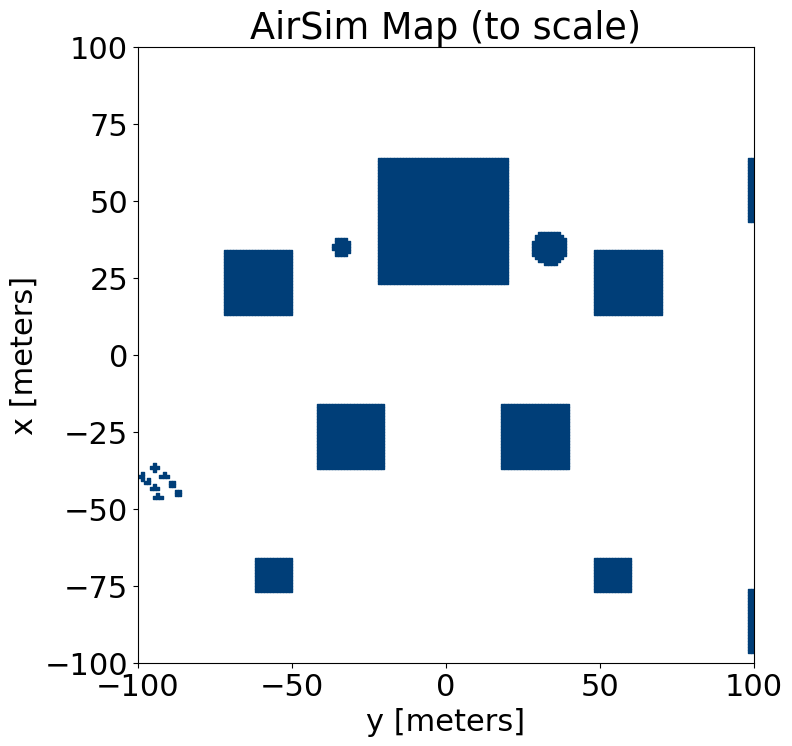

In [19]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8, 8)
# PLOT DRONE PATH
ax1.set_title(f'AirSim Map (to scale)')#' Epoch #{set_num}')
ax1.set_xlabel('y [meters]')
ax1.set_ylabel('x [meters]')
ax1.set_xlim(voxels_trans[0], -1*voxels_trans[0])
ax1.set_ylim(voxels_trans[1], -1*voxels_trans[1])
ax1.set_aspect('equal')
# show objects on map from binvox
plot_map(ax1)
plt.show()

# analyze training metrics


In [20]:
# process final sate values
final_variables = {instance:{} for instance in instances}
for instance in instances:
    for set_num, episodes in enumerate(all_evaluations[instance]):
        for episode, states in enumerate(episodes):
            for step, state in enumerate(states):
                if step == 0:
                    if 'goal_distance' not in final_variables[instance]:
                        final_variables[instance]['goal_distance'] = {}
                    if episode not in final_variables[instance]['goal_distance']:
                        final_variables[instance]['goal_distance'][episode] = []
                    drone_position = np.array(state['drone_position'])
                    goal_position = np.array(state['goal_position'])
                    goal_distance = np.linalg.norm(goal_position - drone_position)
                    final_variables[instance]['goal_distance'][episode].append(goal_distance)
                    continue
            final_state = states[-1]
            for variable in final_state:
                if variable not in final_variables[instance]:
                    final_variables[instance][variable] = {}
                if episode not in final_variables[instance][variable]:
                    final_variables[instance][variable][episode] = []
                final_variables[instance][variable][episode].append(final_state[variable])

# architecture of final_variables:
# instance - str name
    # variable - str name
        # episode - int number
            # final values - list of final values with increased # of training evaluations 

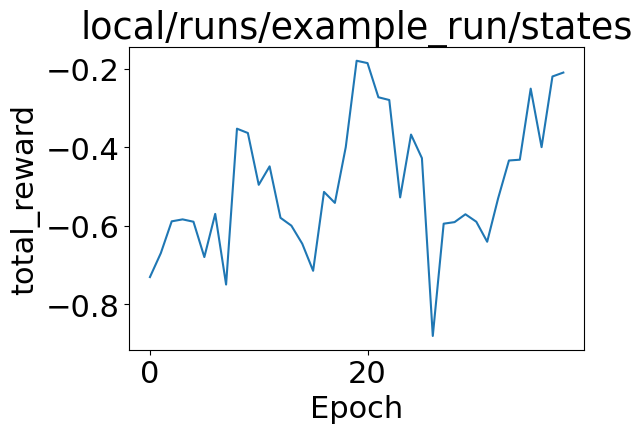

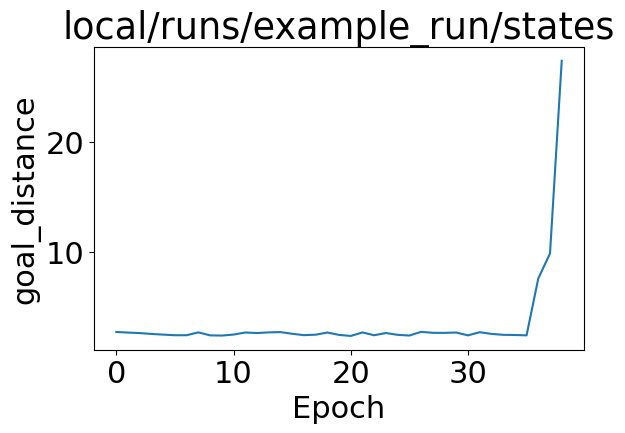

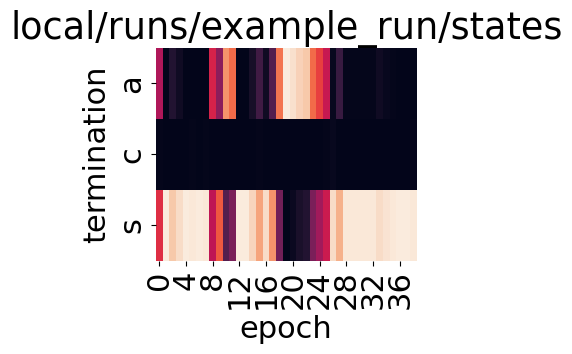

In [21]:
# PLOT RESULTS VERSUS TRAINING TIME
results_instances = [
    train_path + 'states',
]
# select which state variables to fetch
numerical_variables = [
    #'nSteps', 
    'total_reward', 
    'goal_distance',
]
string_variables = [
    #'transcribed_action', 
    'termination_reason',
]
all_variables = numerical_variables + string_variables

shorten = {
    'termination_reason':'termination',
}

# take mean values
for variable in all_variables:
    for instance in results_instances:
        if variable not in shorten:
            shorten[variable] = variable
        plot_name = instance + '_' + variable
        
        values = {}
        for episode in final_variables[instance][variable]:
            for evaluation in range(len(final_variables[instance][variable][episode])):
                if evaluation not in values:
                    values[evaluation] = []
                values[evaluation].append(final_variables[instance][variable][episode][evaluation])

        if variable in numerical_variables:
            aggregates = []
            nEpisodes = len(final_variables[instance][variable])
            for evaluation in values:
                aggregates.append(sum(values[evaluation])/len(values[evaluation]))
            plt.title(instance)
            plt.xlabel('Epoch')
            plt.ylabel(variable)
            plt.plot(aggregates)
            plt.tight_layout()
            #fig = plt.gcf()
            #fig.set_size_inches(8, 4)
            #plt.savefig(plot_dir + plot_name + '.png')
            plt.show()

        if variable in string_variables:
            fig = plt.gcf()
            fig.set_size_inches(4, 4)
            aggregates = {}
            for evaluation in values:
                for name in values[evaluation]:
                    if name not in aggregates:
                        aggregates[name] = {}
                    if evaluation not in aggregates[name]:
                        aggregates[name][evaluation] = 0
                    aggregates[name][evaluation] += 1   
            df_data = {'count':[], shorten[variable]:[], 'epoch':[]}
            for name in aggregates:
                for evaluation in values:
                    if evaluation not in aggregates[name]:
                        aggregates[name][evaluation] = 0
                    count = aggregates[name][evaluation]
                    df_data['count'].append(count)
                    df_data[shorten[variable]].append(name[0])
                    df_data['epoch'].append(evaluation)
            df = pd.DataFrame(df_data)
            heatmap_data = pd.pivot_table(df, values='count', index=[shorten[variable]], columns='epoch')
            sns.heatmap(heatmap_data, cbar=False)
            #plt.imshow(heatmap_data.to_numpy())
            plt.title(instance)
            plt.tight_layout()
            #plt.savefig(plot_dir + plot_name + '.png')
            plt.show()

# view learned navigation paths

0


/tmp/ipykernel_200960/3473810837.py:68: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
/tmp/ipykernel_200960/3473810837.py:69: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1)
/tmp/ipykernel_200960/3473810837.py:70: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)


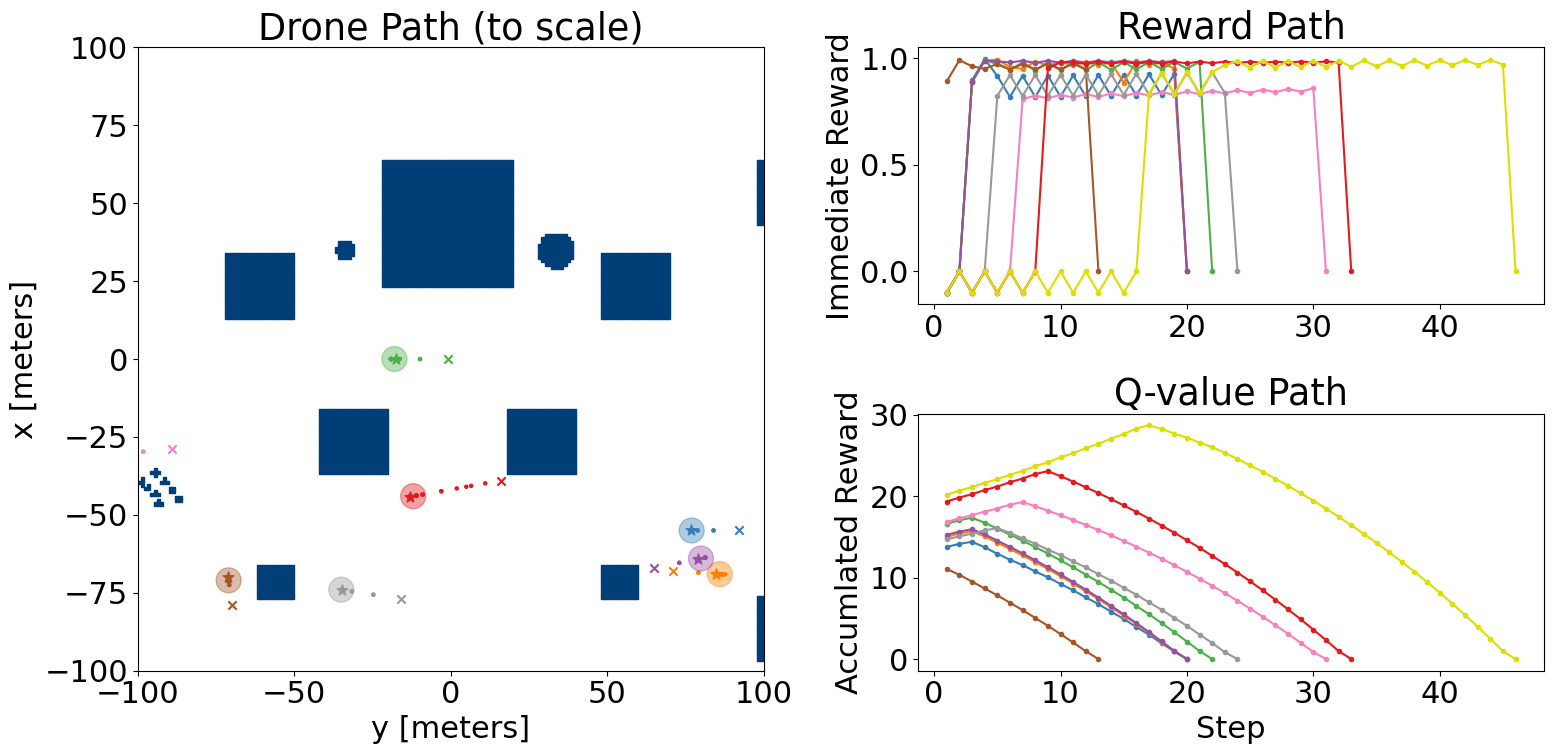

0


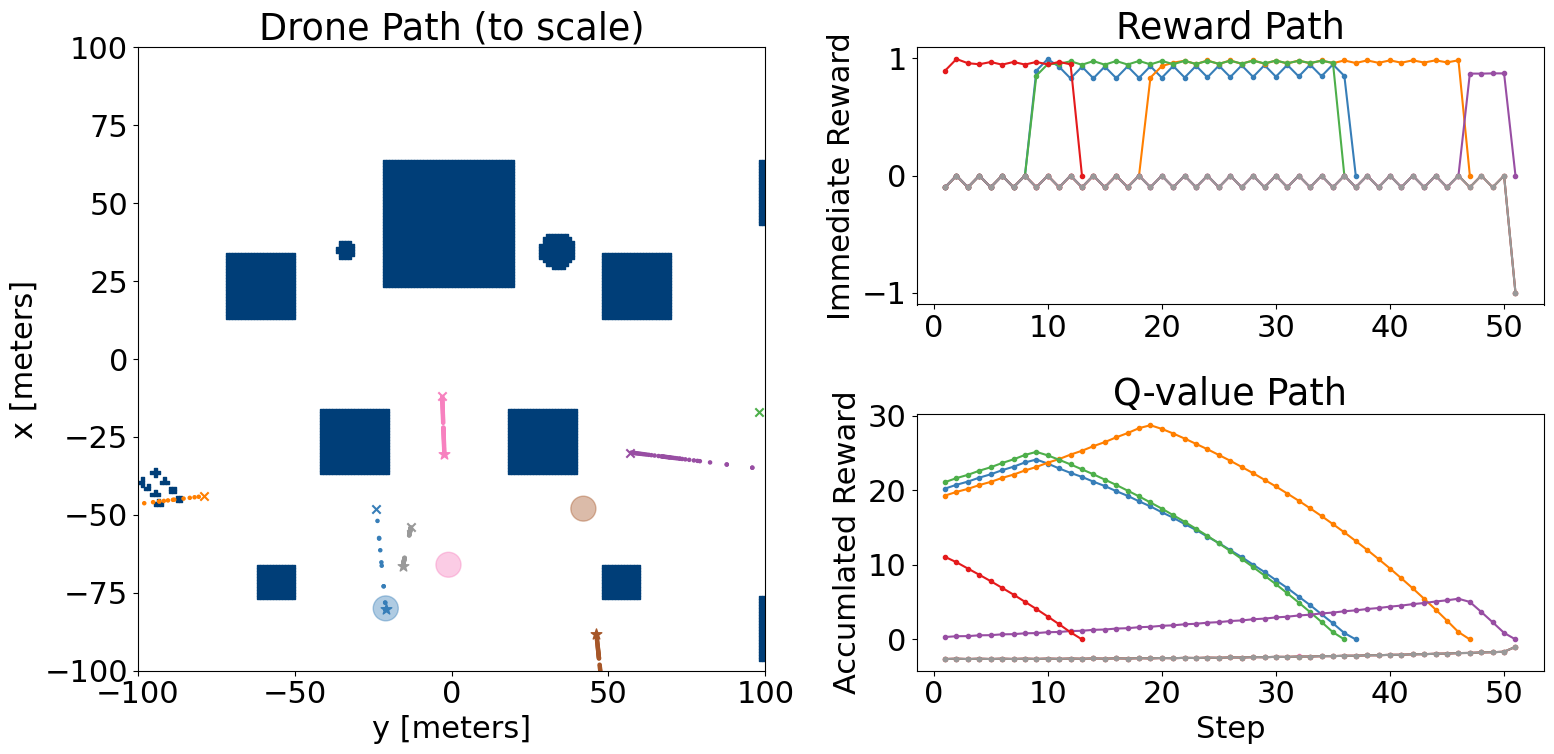

0


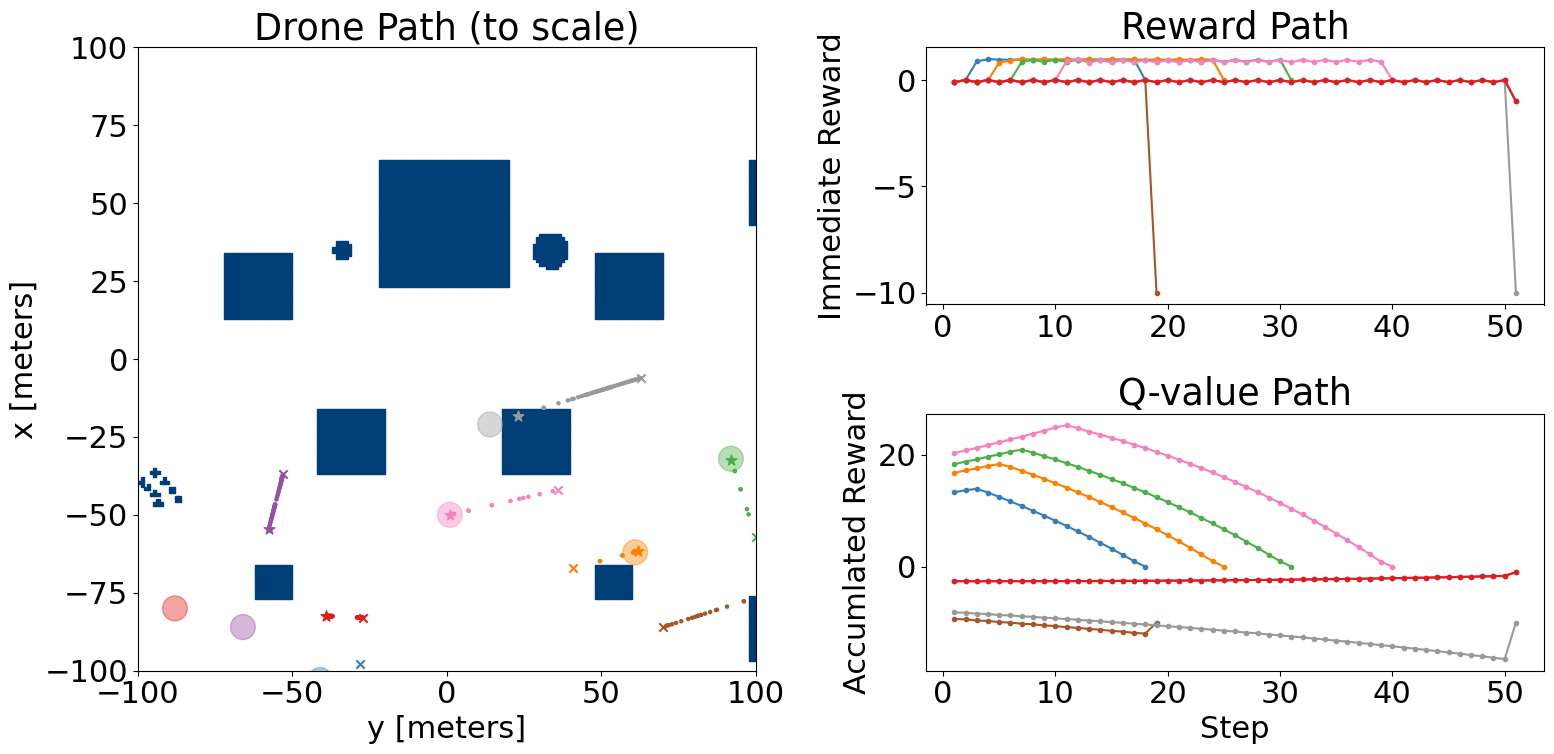

0


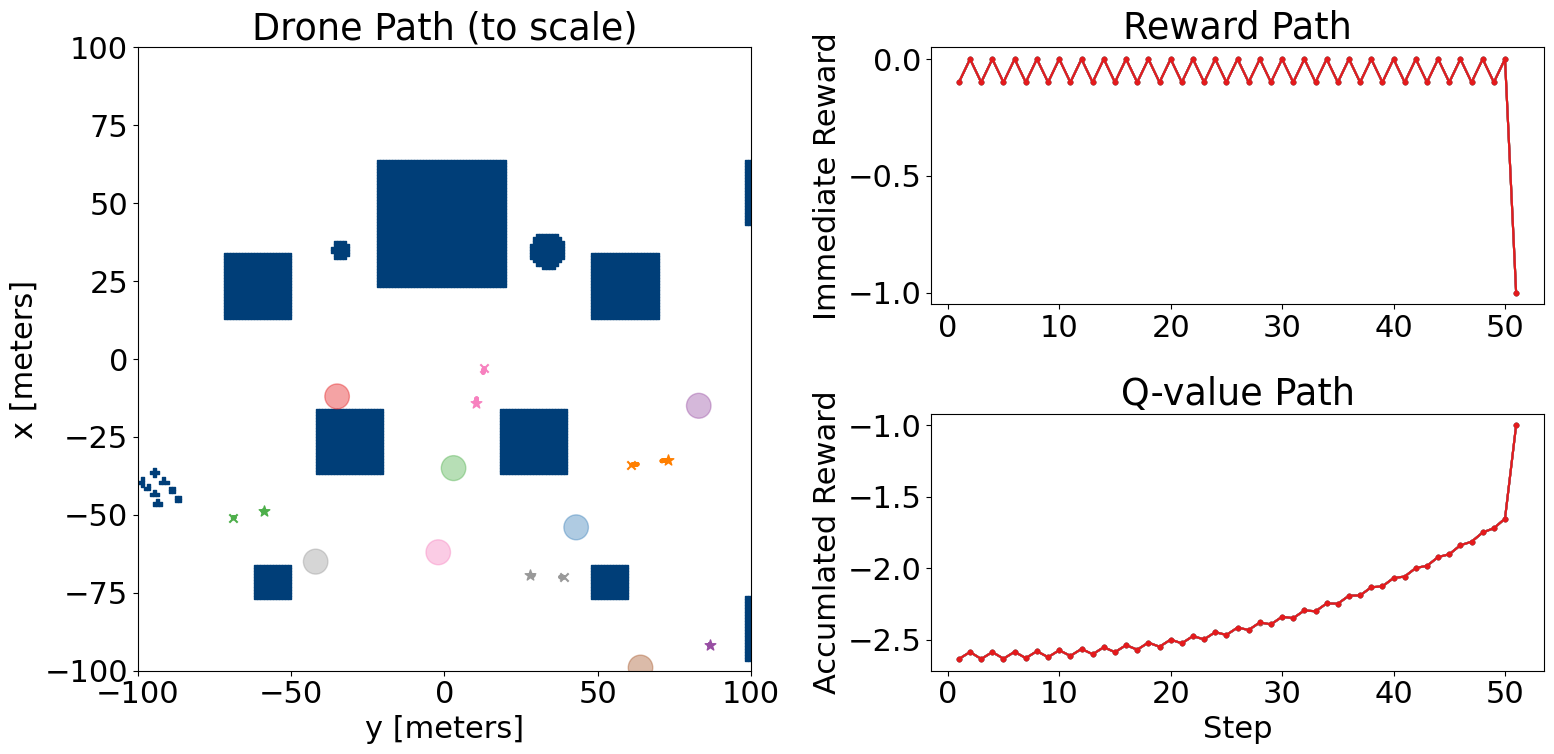

0


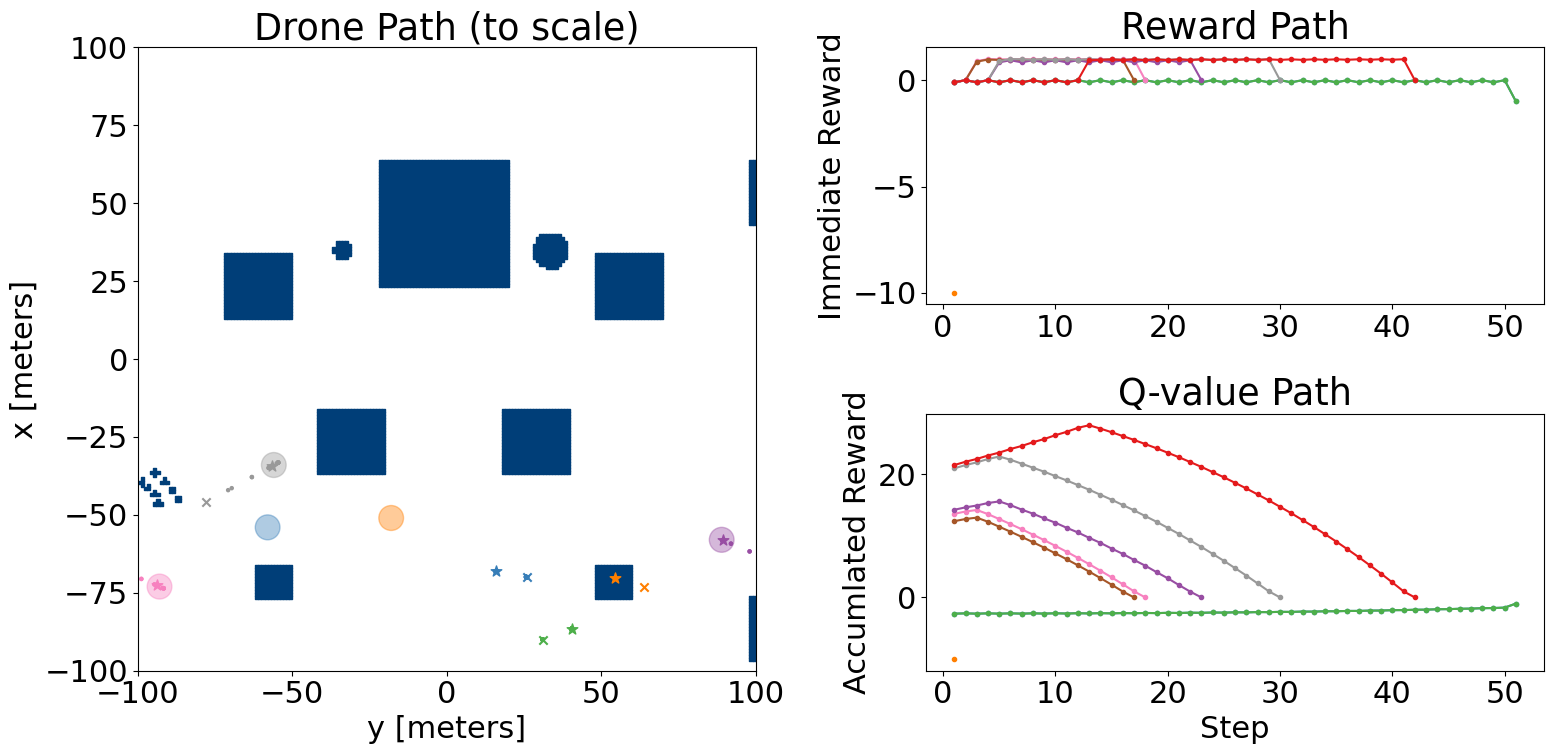

0


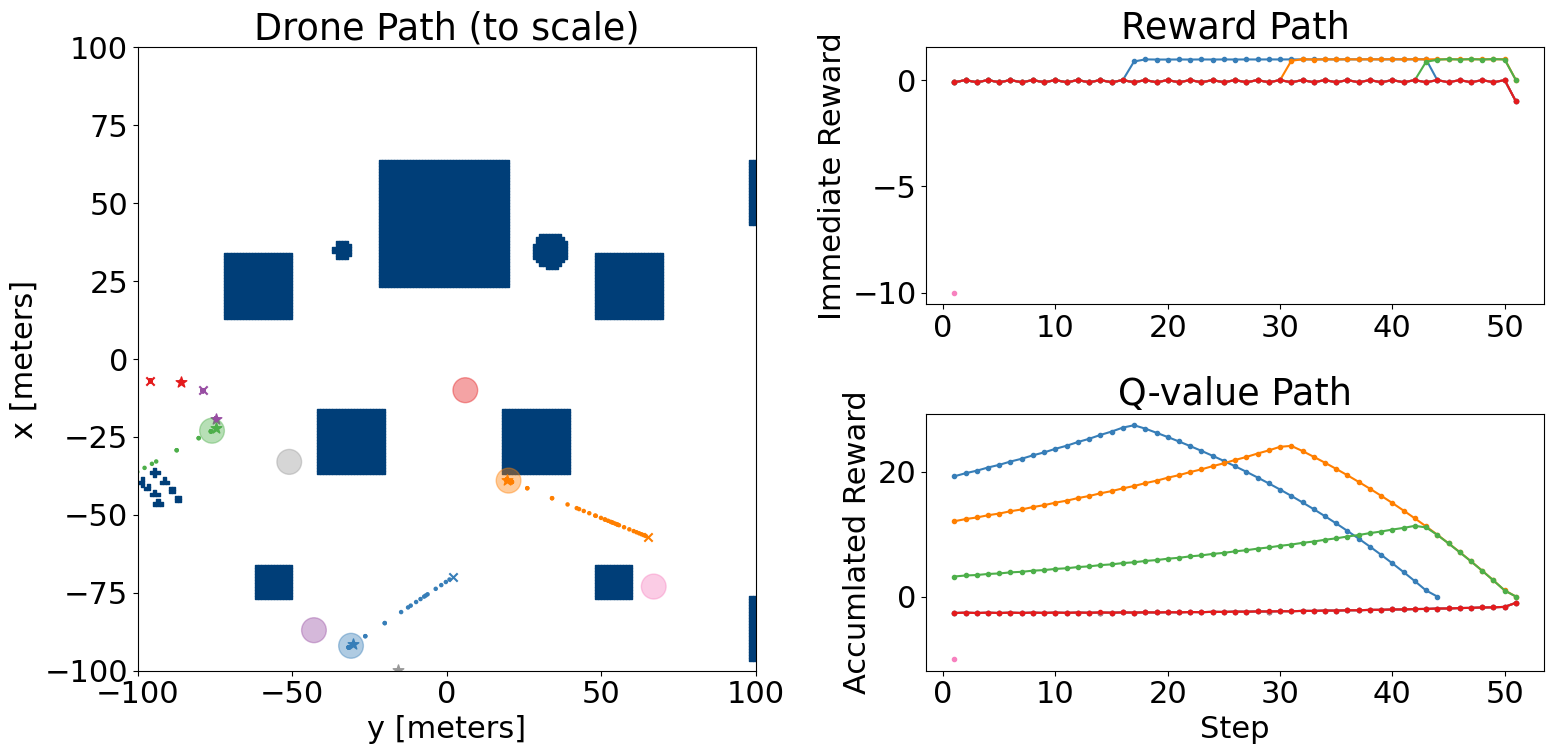

0


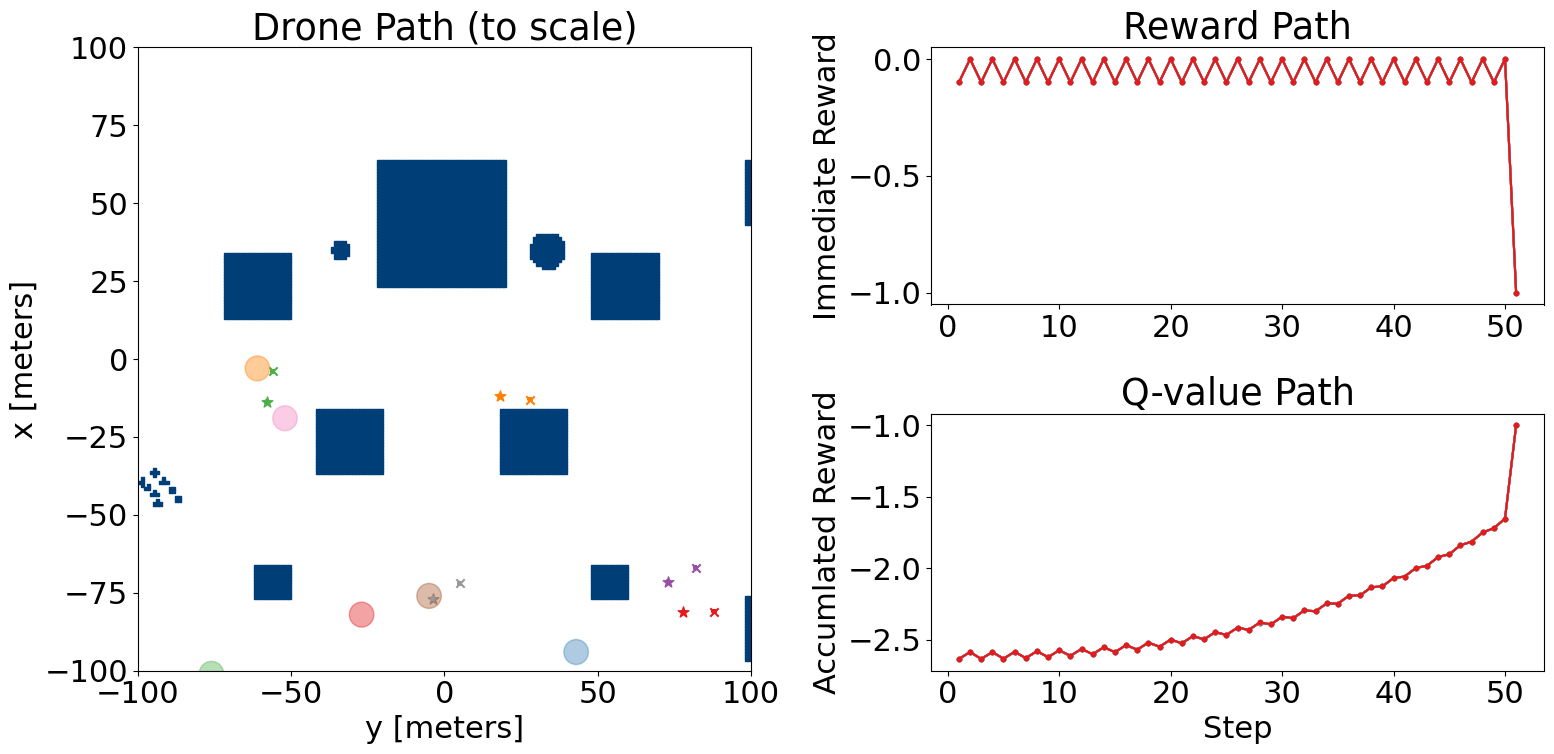

0


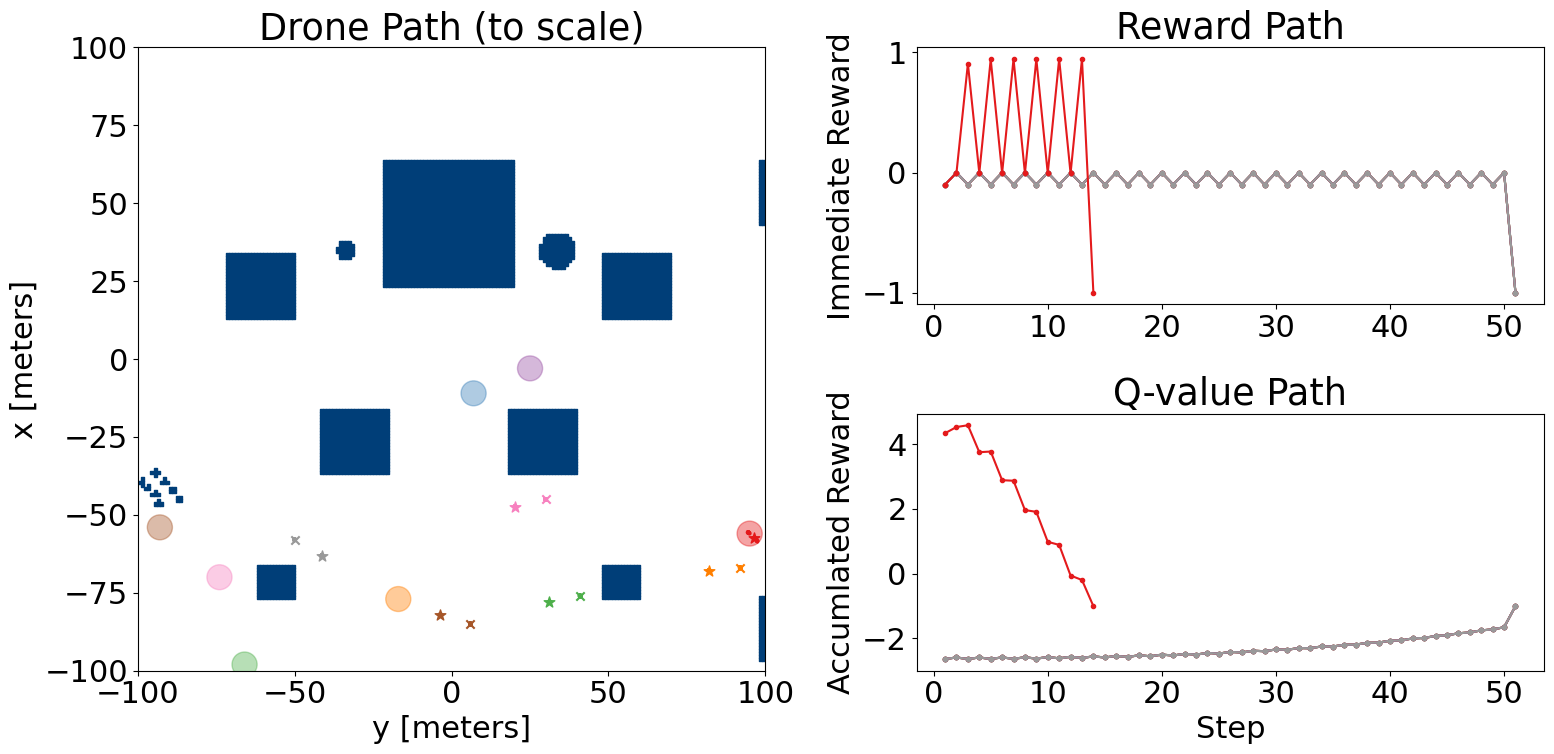

0


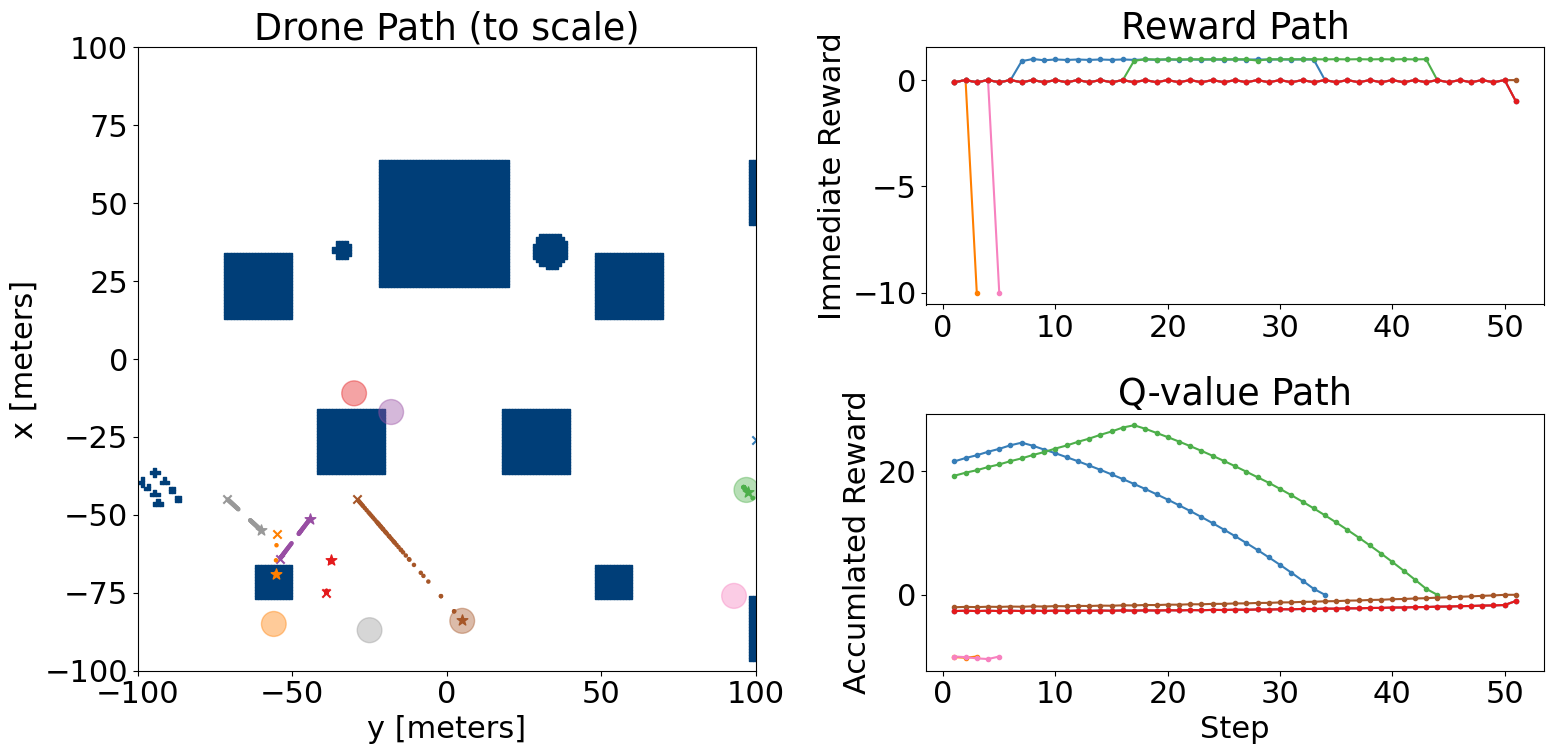

0


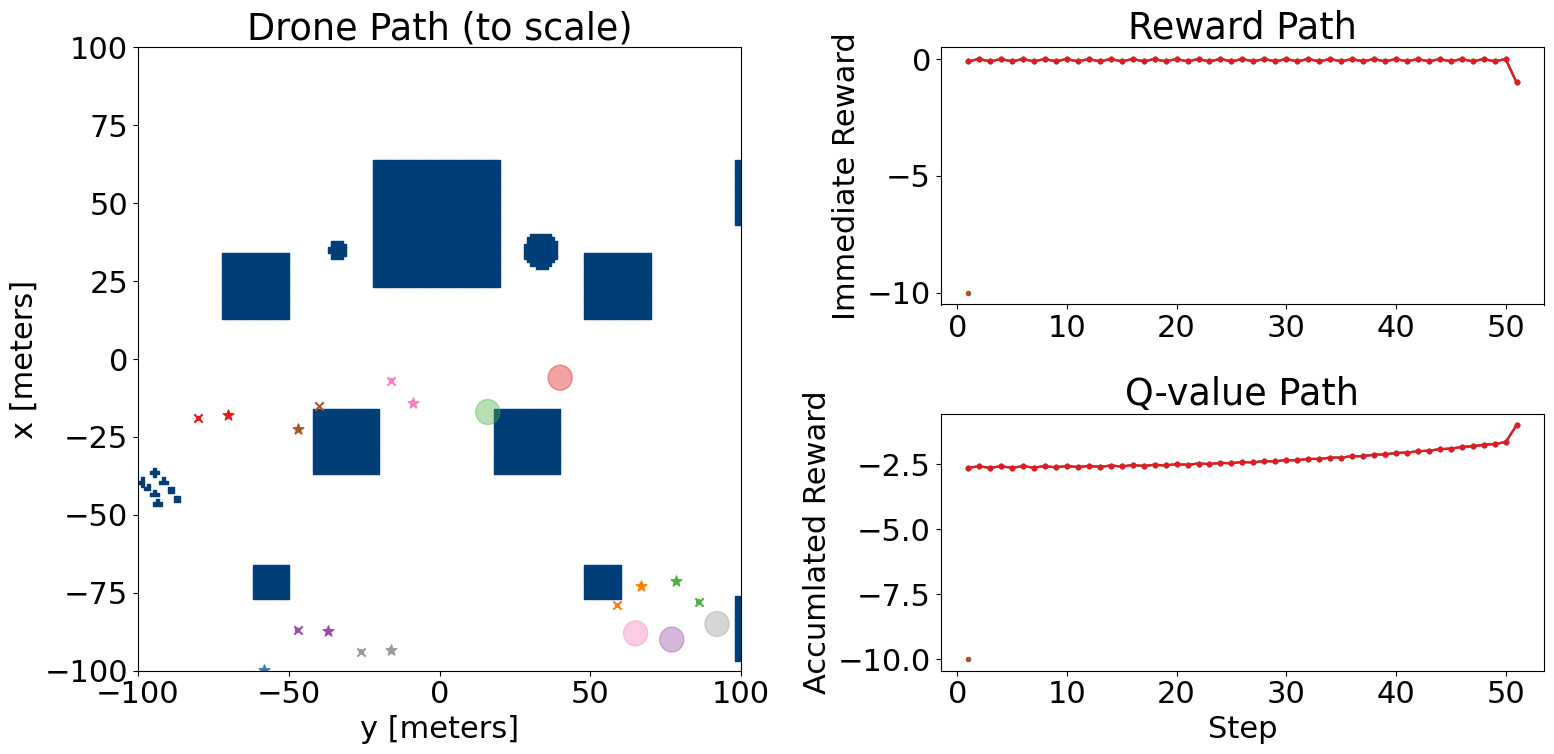

0


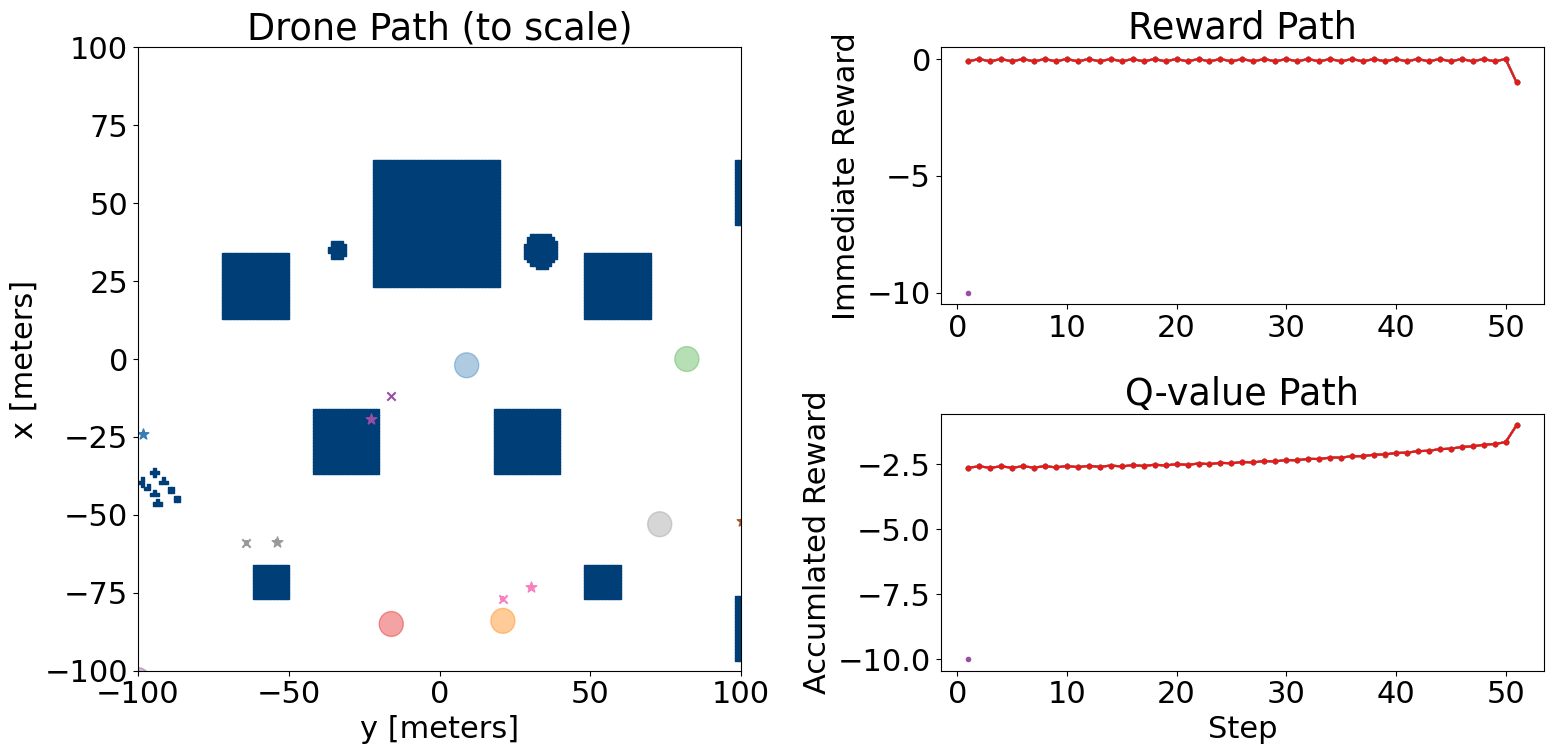

0


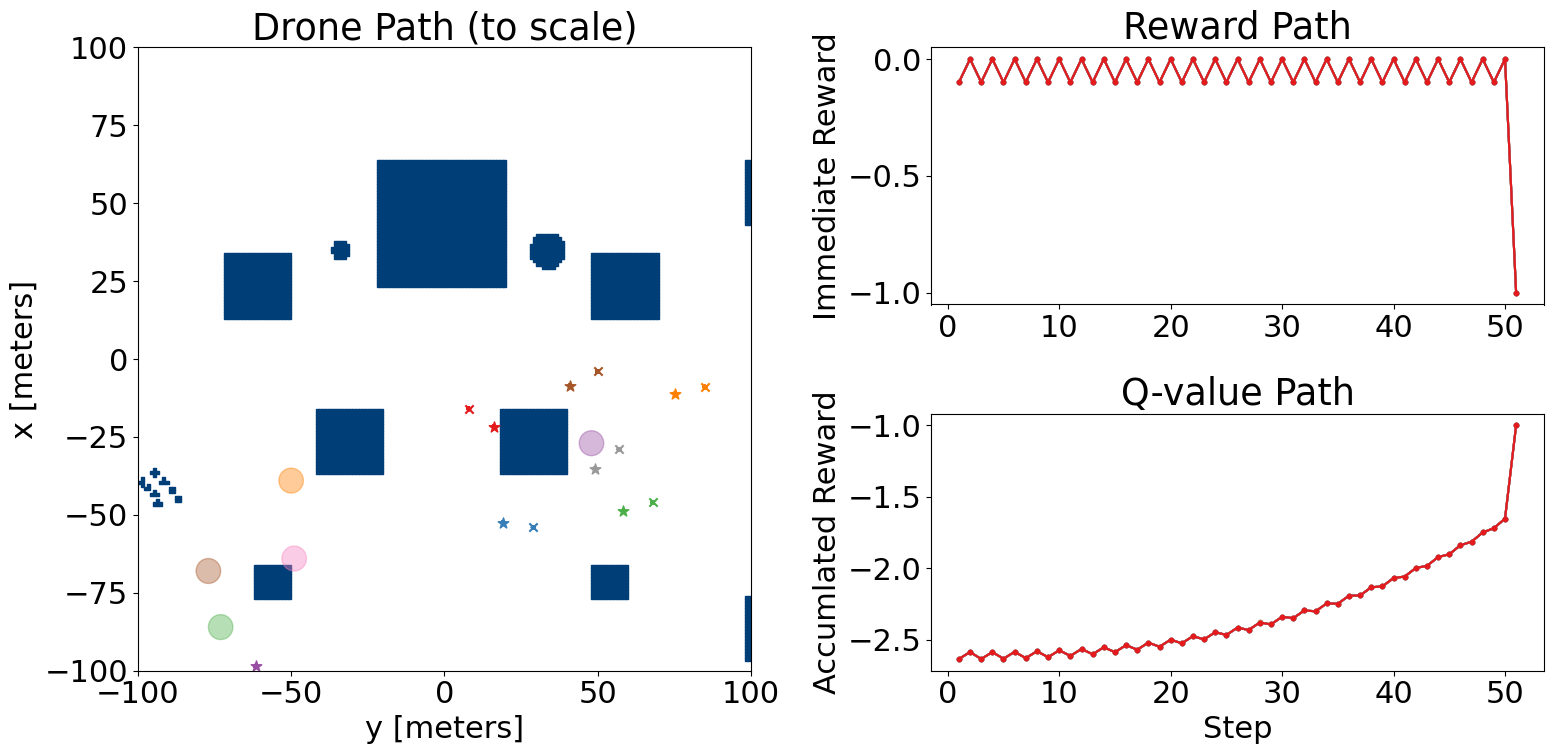

0


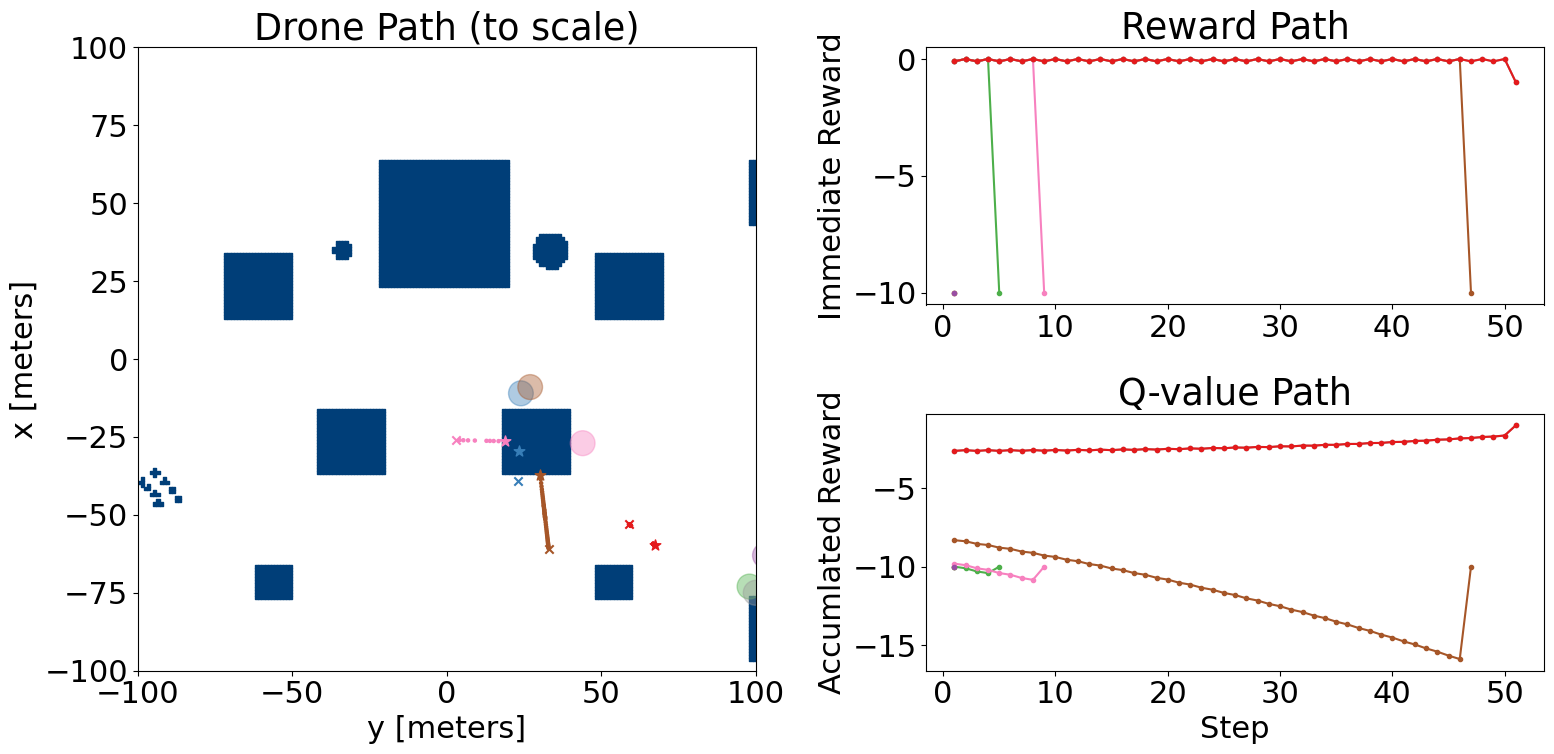

0


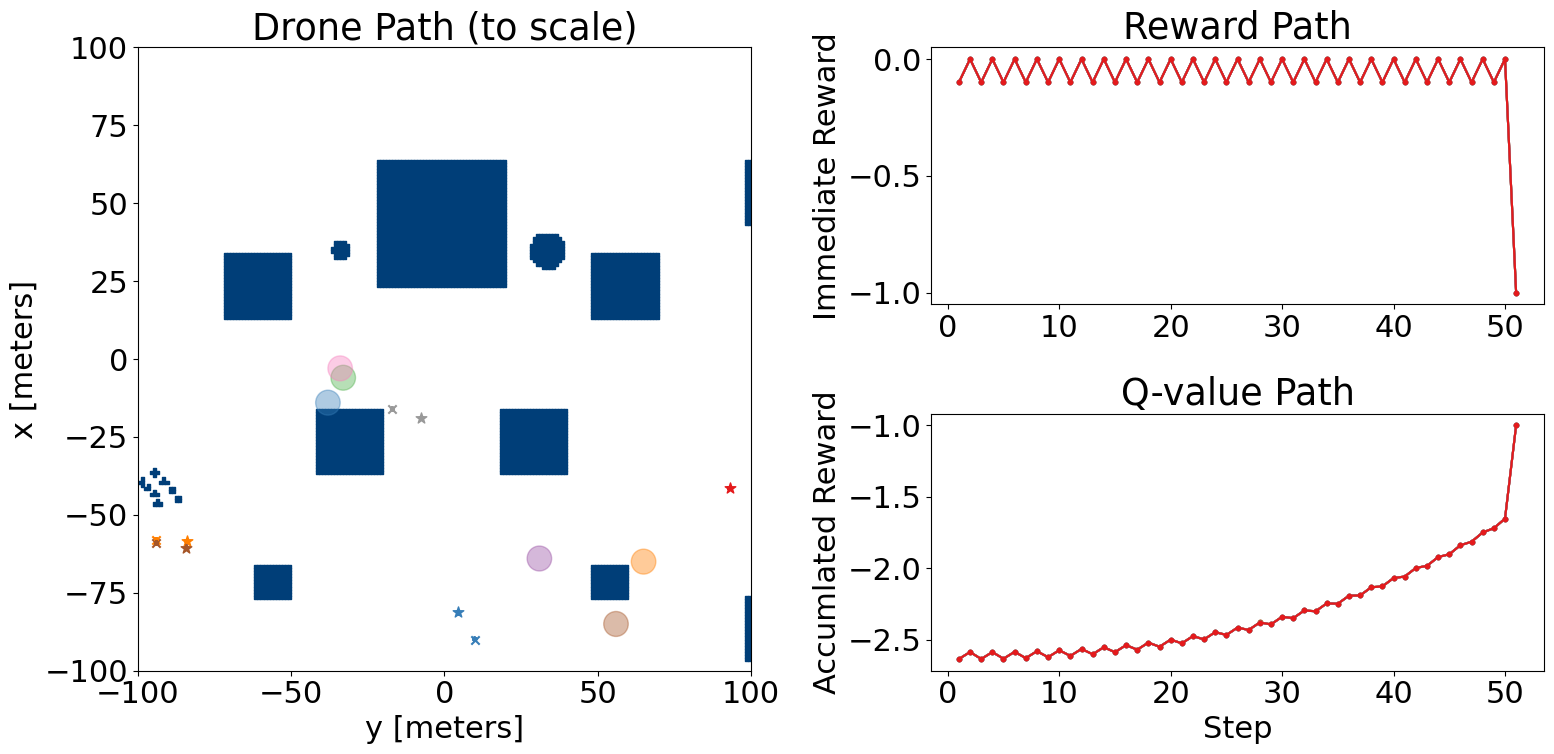

0


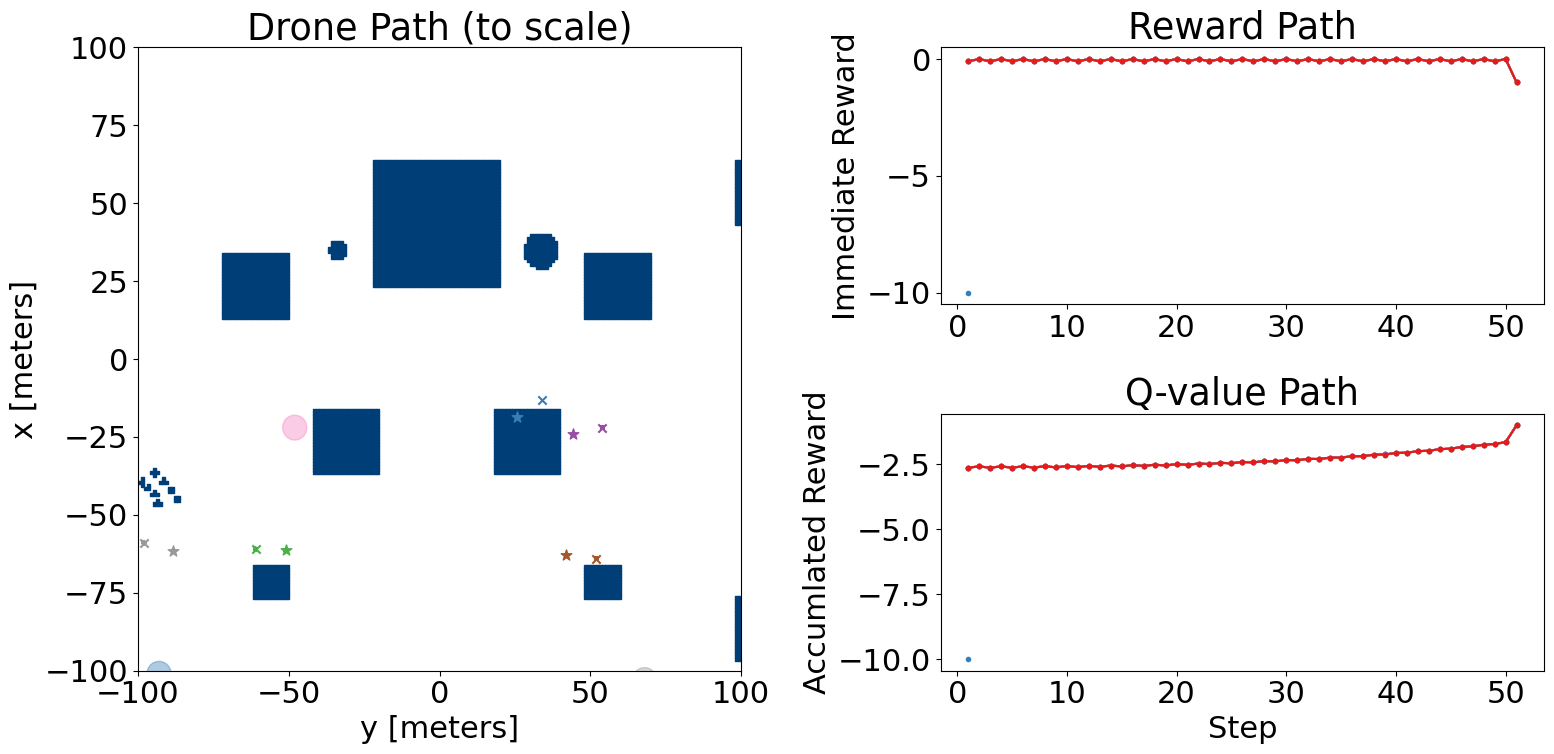

0


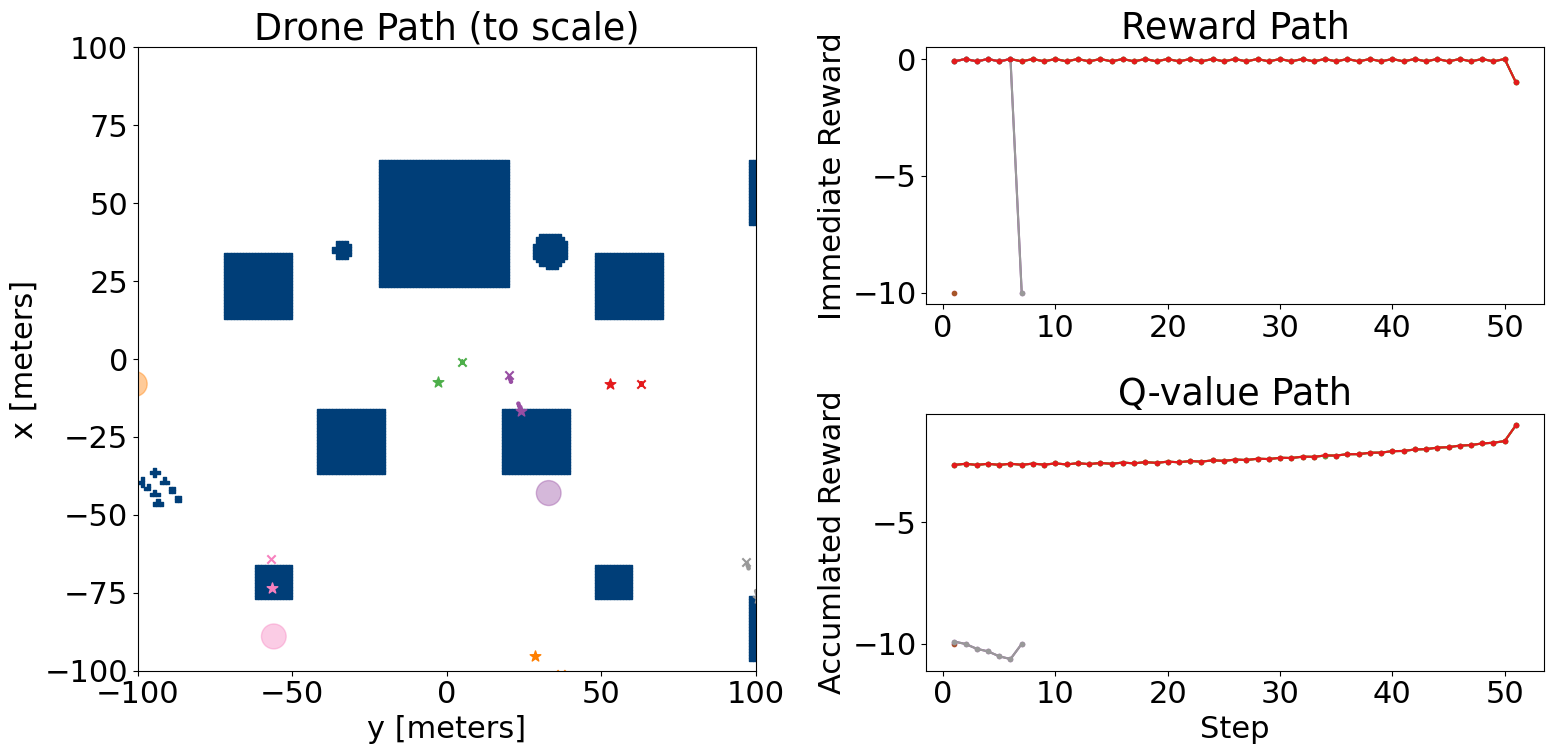

0


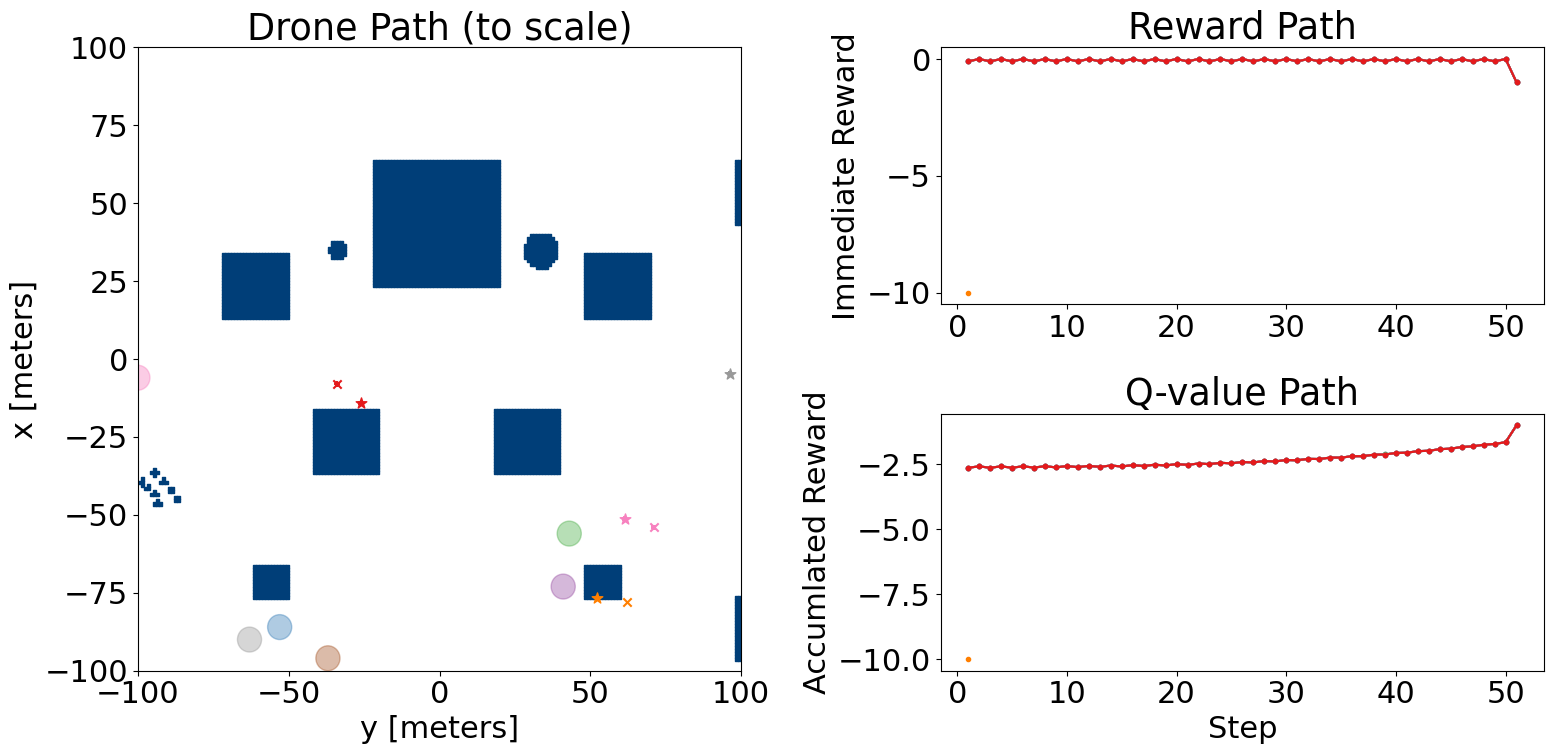

0


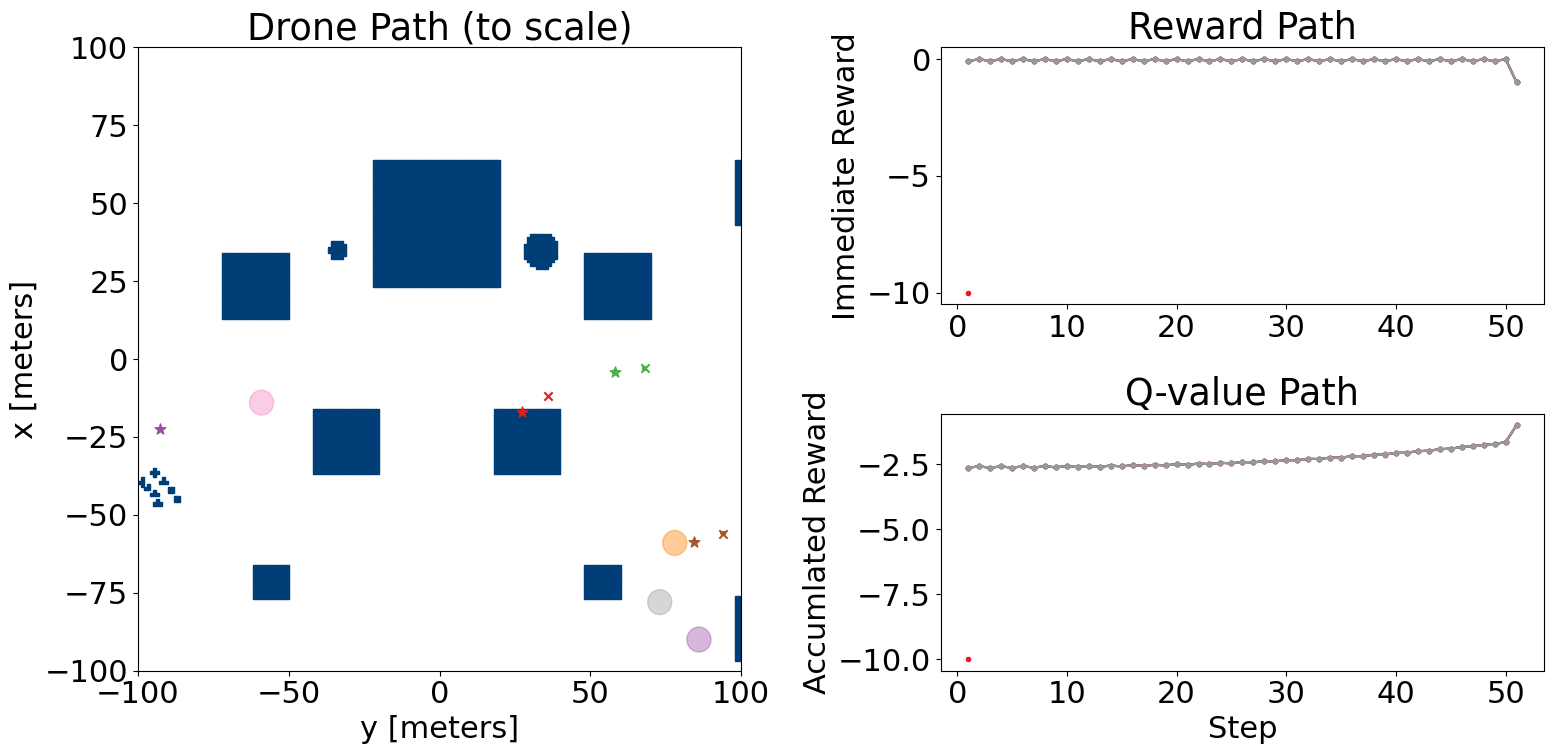

0


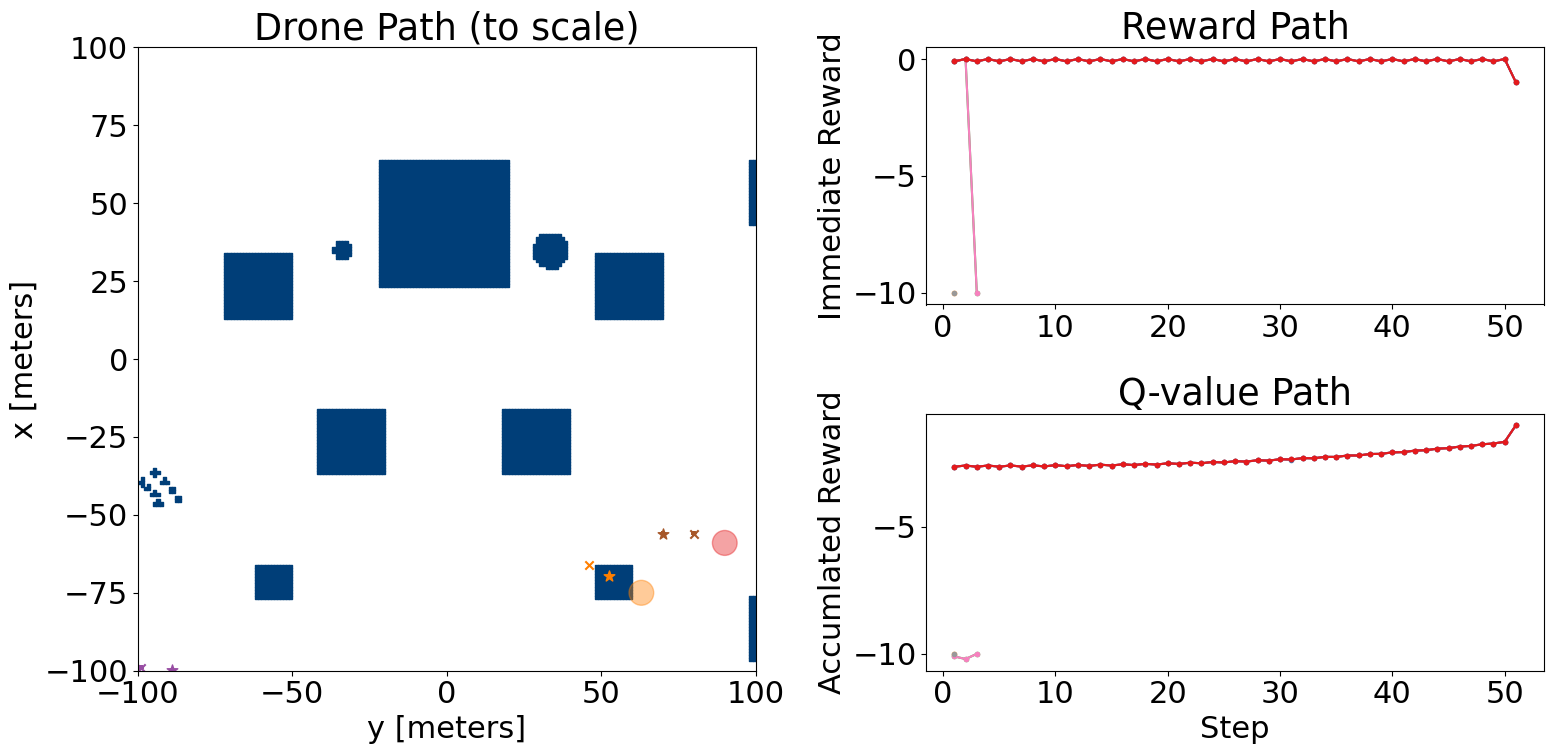

0


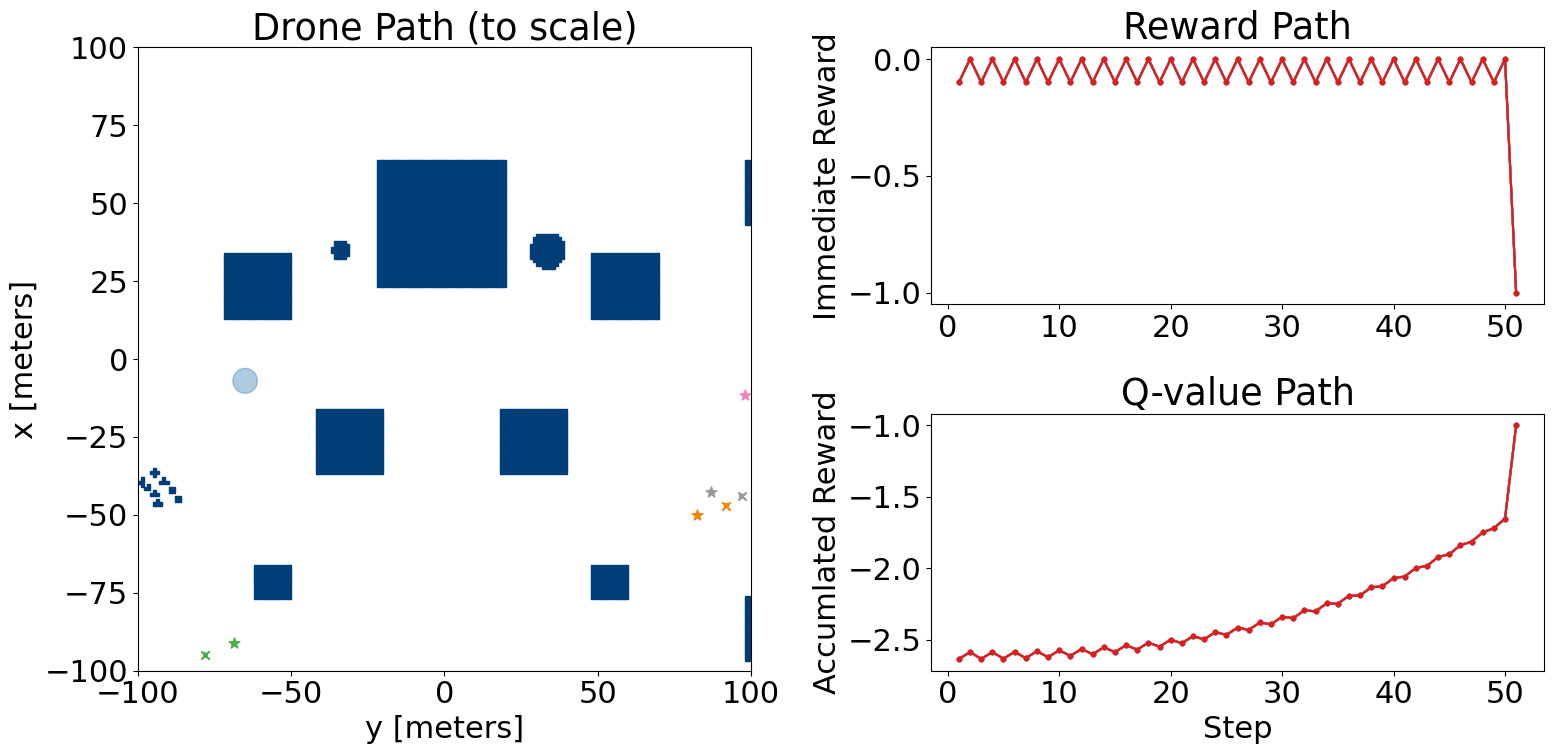

0


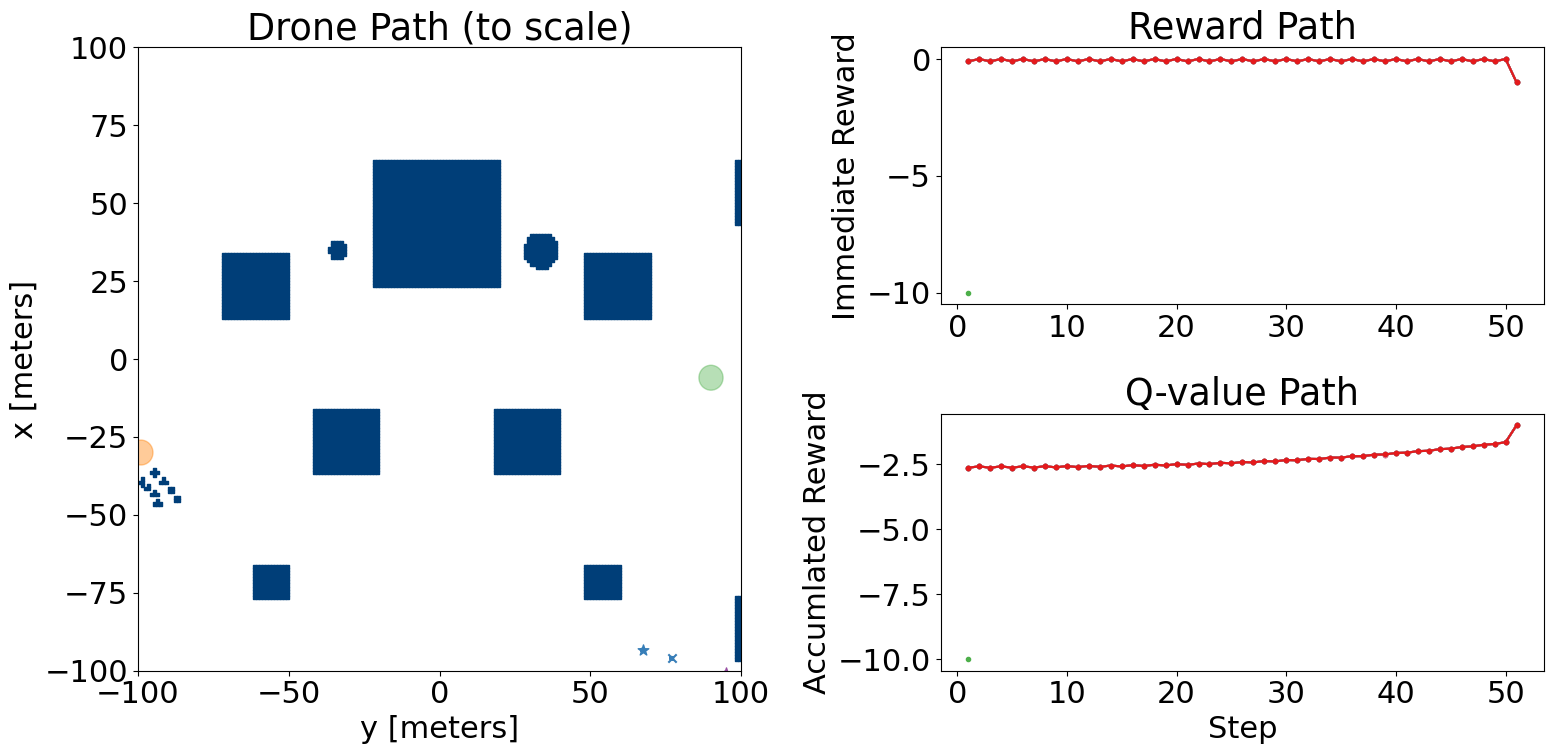

0


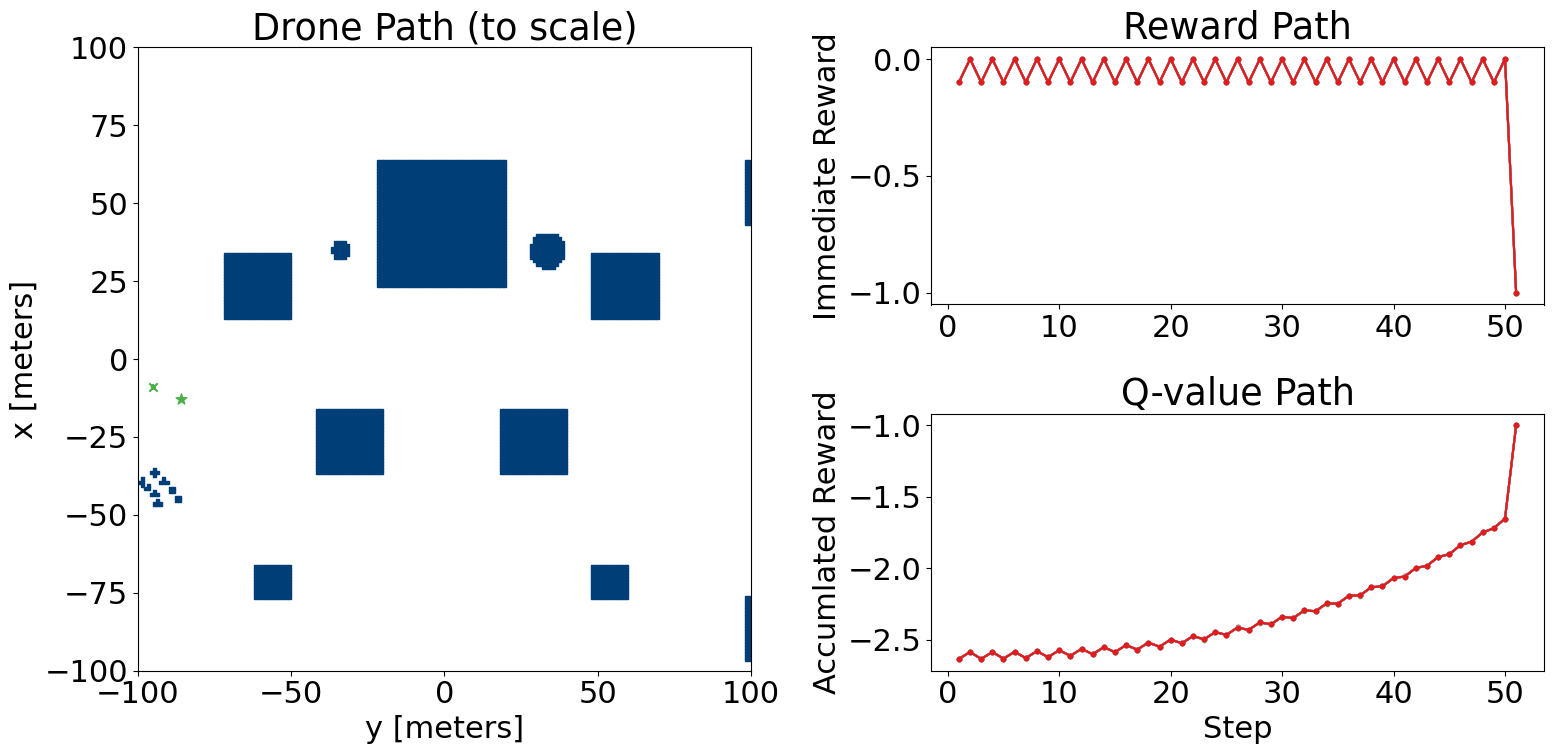

0


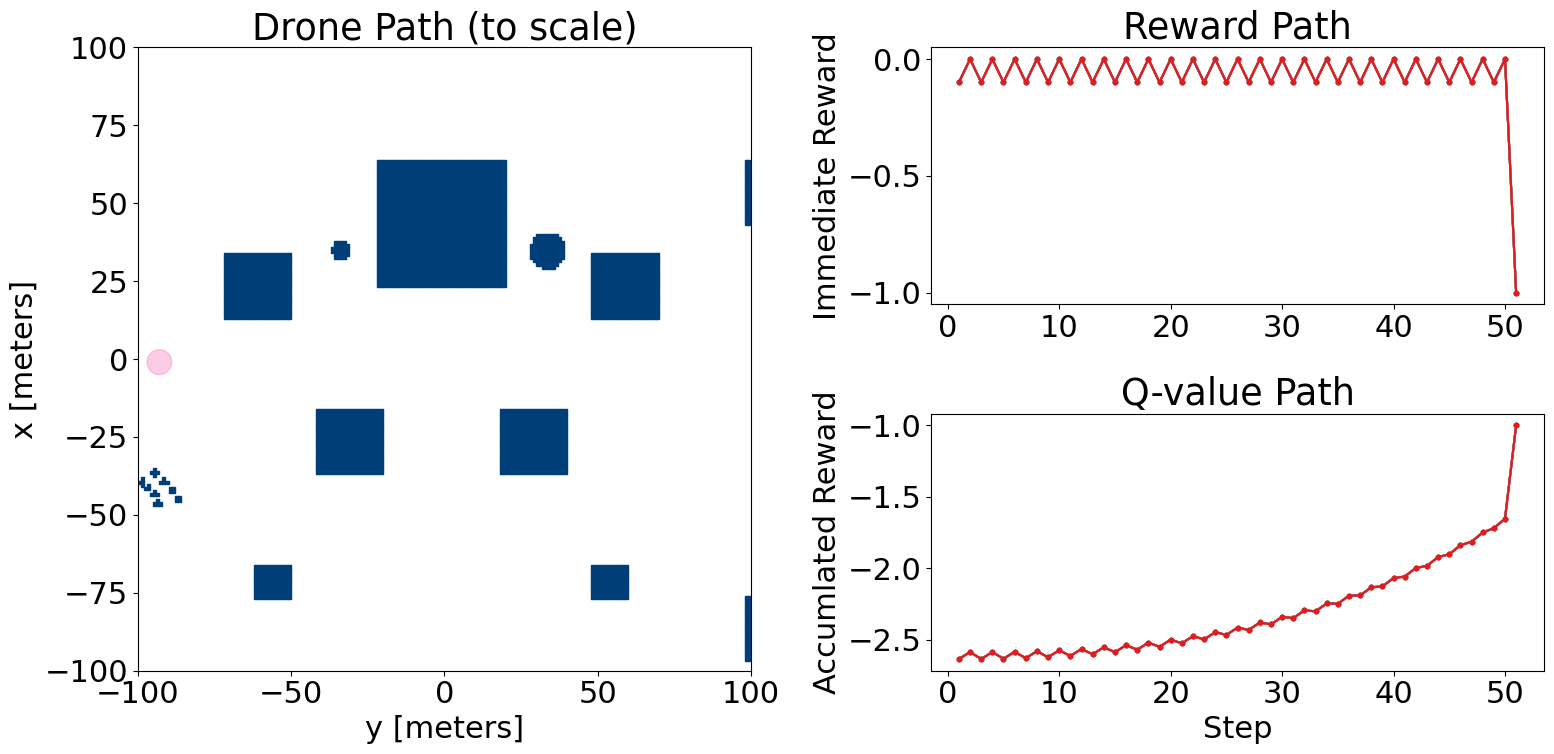

0


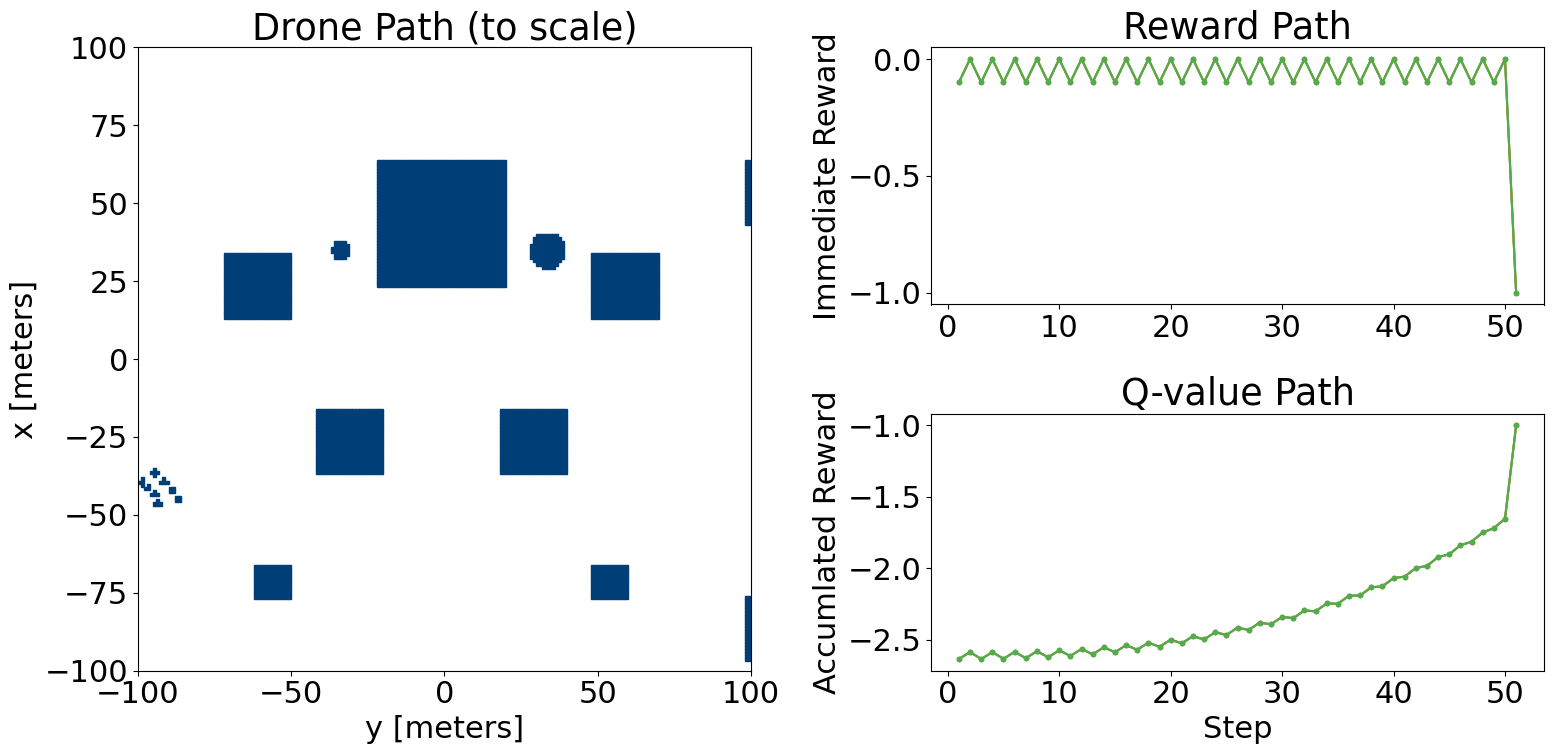

In [22]:
# PLOT PATHS (this is alot so you probably want to limit which ones to visualize
gamma = train_configuration['components']['Model']['gamma']
goal_tolerance = 4
path_instances = [
    #train_path + 'train_states',
    test_path + 'states',
]
for instance in path_instances:
    evaluations = all_evaluations[instance]
    for set_num, episodes in enumerate(evaluations):
        paths = []
        reward_paths = []
        Q_paths = []
        goals = []
        spawns = []
        termination_reasons = []
        episode_numbers = []
        # do we plot this set? (change as needed)
        # you can just plot everything but its alot to chew
        view_set = True
        for episode, states in enumerate(episodes):
            # get final vaules
            final_state = episodes[episode][-1]
            reached_goal = final_state['reached_goal']
            #if not reached_goal:
            #    view_set = False
            #    break
        if not view_set:
            continue
        for episode, states in enumerate(episodes):
            # get final vaules
            final_state = episodes[episode][-1]
            termination_reason = final_state['termination_reason']
            # build paths
            path = []
            reward_path = []
            Q_path = []
            episode_numbers.append(episode)
            # get initial value
            init_state = states[0]
            spawn = init_state['drone_position']
            goal = init_state['goal_position']
            # get intermediate values
            for step, state in enumerate(states):
                if step == 0: continue
                state = episodes[episode][step]
                drone_position = state['drone_position']
                path.append(drone_position)
                reward = state['total_reward']
                reward_path.append(reward)
                # get future values from this state
                for step2, state2 in enumerate(states[step+1:]):
                    if step == 0: continue
                    reward += (gamma**(step2-step)) * state2['total_reward']
                Q_path.append(reward)
            reward_paths.append(reward_path)
            termination_reasons.append(termination_reason)
            spawns.append(spawn)
            goals.append(goal)
            paths.append(path)
            Q_paths.append(Q_path)
            # plot every 8 episodes 
            if episode == len(episodes)-1 or (episode > 0 and episode%8 == 0):
                print(set_num)
                # subplots
                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
                fig.set_size_inches(16, 8)
                ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
                ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1)
                ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
                # PLOT DRONE PATH
                ax1.set_title(f'Drone Path (to scale)')#' Epoch #{set_num}')
                ax1.set_xlabel('y [meters]')
                ax1.set_ylabel('x [meters]')
                ax1.set_xlim(voxels_trans[0], -1*voxels_trans[0])
                ax1.set_ylim(voxels_trans[1], -1*voxels_trans[1])
                # show objects on map from binvox
                plot_map(ax1)
                # legend hack
                ax1.scatter(-999, -999, marker='s', color=object_color) # off map just for legend
                legend = [
                #    'Objects'
                ]
                for idx in range(len(termination_reasons)):
                    color = color_blinds_list[idx]
                    ax1.scatter(spawns[idx][1], spawns[idx][0], marker='x', color=color) # spawn location
                    termination_reason = termination_reasons[idx]
                    legend.append('E' + str(episode_numbers[idx]) + ':' + termination_reason)
                plt_patches = []
                for idx in range(len(paths)):
                    color = color_blinds_list[idx]
                    # plot goal
                    obj = plt.Circle((goals[idx][1], goals[idx][0]), goal_tolerance, color=color, alpha=0.4)
                    plt_patches.append(obj)
                    # plot points
                    for point in paths[idx]:
                        # using generic quad copter size for point sizes (set this to your drone value)
                        radius = 0.5 #* point[2]/-4
                        point = plt.Circle((point[1], point[0]), radius, color=color)
                        plt_patches.append(point)
                    # plot end point
                    ax1.scatter(paths[idx][-1][1], paths[idx][-1][0], marker='*', s=64, color=color) # end location
                map_stuff = PatchCollection(plt_patches, match_original=True)
                ax1.add_collection(map_stuff)
                # PLOT REWARDS
                ax2.set_title('Reward Path')
                #ax2.set_xlabel('Step')
                ax2.set_ylabel('Immediate Reward')
                for idx in range(len(reward_paths)):
                    color = color_blinds_list[idx]
                    ax2.plot([i+1 for i in range(len(reward_paths[idx]))], reward_paths[idx], color=color, marker='.')
                # PLOT Q-VALUES
                ax3.set_title('Q-value Path')
                ax3.set_xlabel('Step')
                ax3.set_ylabel('Accumlated Reward')
                for idx in range(len(Q_paths)):
                    color = color_blinds_list[idx]
                    ax3.plot([i+1 for i in range(len(Q_paths[idx]))], Q_paths[idx], color=color, marker='.')
                # plot legend
                #ax2.legend(legend)
                plt.tight_layout()
                # Show the graph
                plot_name = instance + '_best_path'
                #plt.savefig(plot_dir + plot_name + '.png')
                plt.show()
                # reset path arrays
                paths = []
                reward_paths = []
                Q_paths = []
                goals = []
                spawns = []
                termination_reasons = []
                episode_numbers = []

# view observations

V118190_V118191_V118192 at step=0 t=0 d=15.0 o=-3.422854266688091e-08


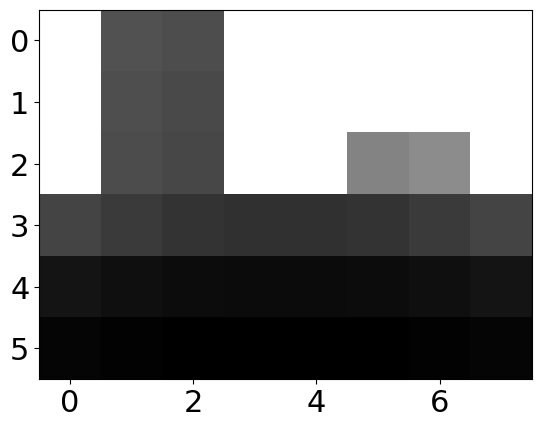

V118194_V118195_V118196 at step=1 t=1 d=6.997352600097656 o=3.1415925192309544


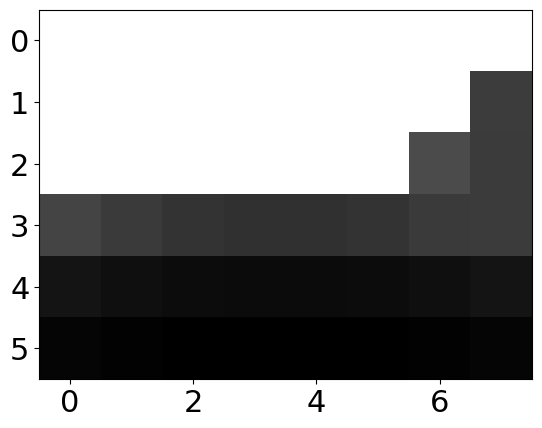

V118198_V118199_V118200 at step=2 t=2 d=6.997352600097656 o=0.0001542291751817082


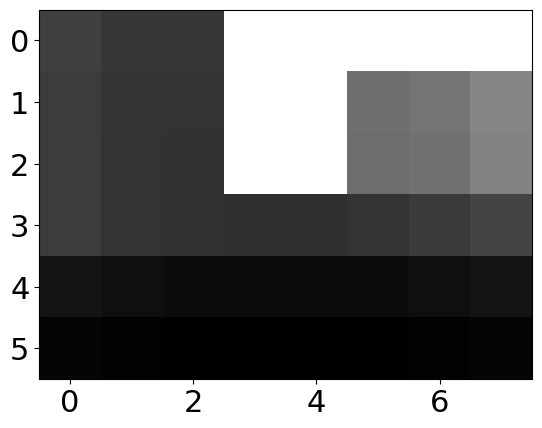

V118202_V118203_V118204 at step=3 t=3 d=1.9325944575348717 o=-3.1410337237340036


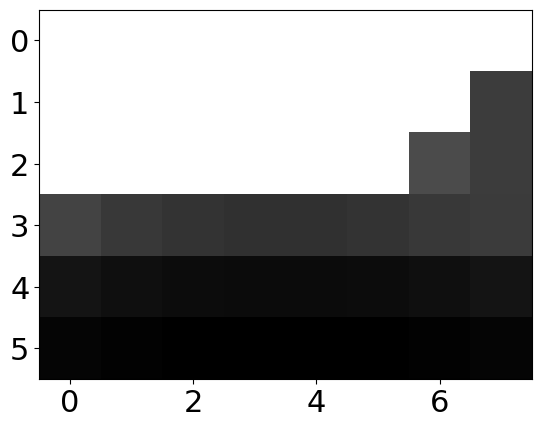

V118206_V118207_V118208 at step=4 t=4 d=1.9325944575348717 o=0.0008450086304168103


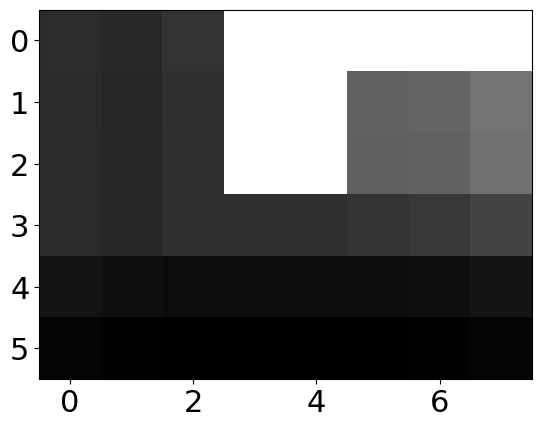

V118210_V118211_V118212 at step=5 t=5 d=0.1761176058568878 o=-0.009263470631473592


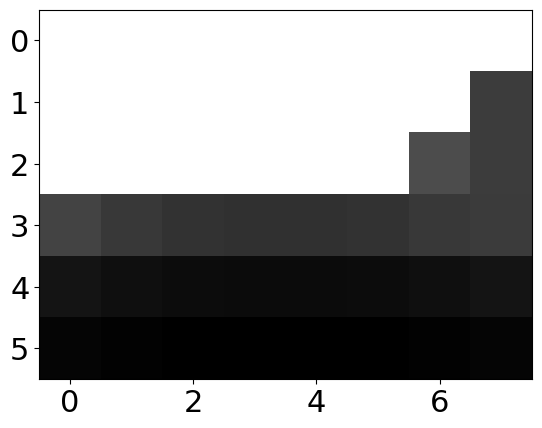

V118214_V118215_V118216 at step=6 t=6 d=0.1761176058568878 o=3.133134387099669


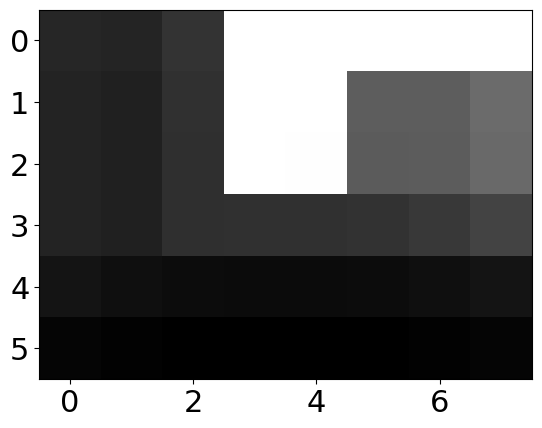

V118218_V118219_V118220 at step=7 t=7 d=0.1761176058568878 o=-0.008458299348109488


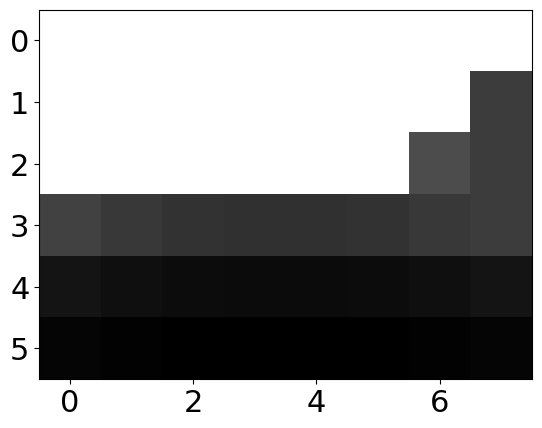

V118222_V118223_V118224 at step=8 t=8 d=0.1761176058568878 o=3.133972120910963


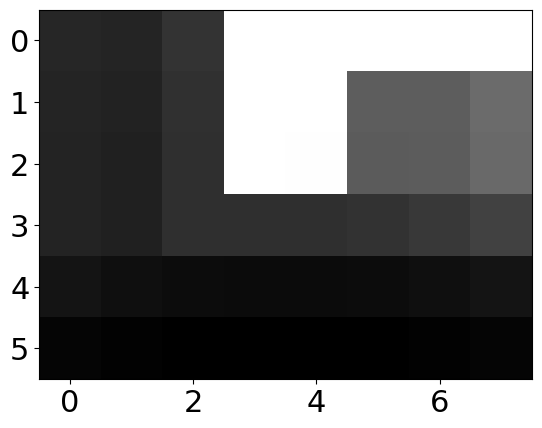

V118226_V118227_V118228 at step=9 t=9 d=0.1761176058568878 o=-0.007620611106232467


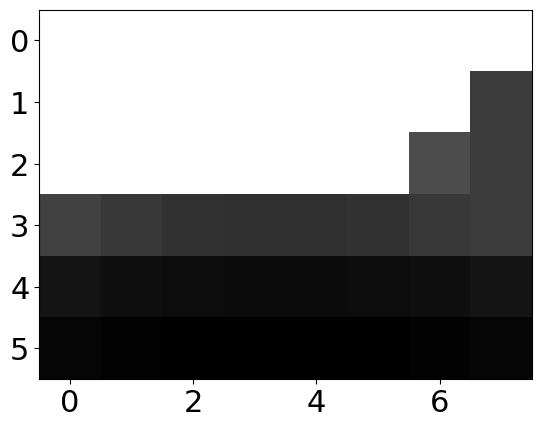

V118230_V118231_V118232 at step=10 t=10 d=0.1761176058568878 o=3.134849883173228


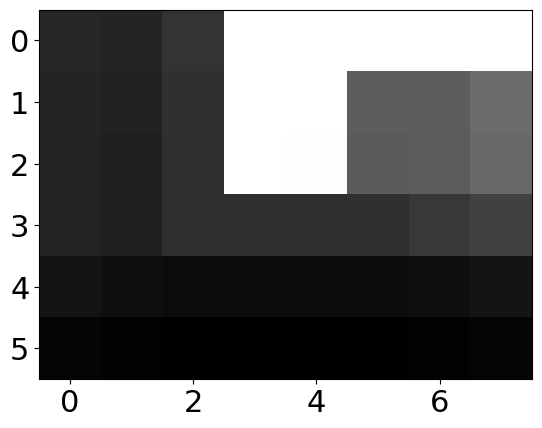

V118234_V118235_V118236 at step=11 t=11 d=0.1761176058568878 o=-0.006742702654786381


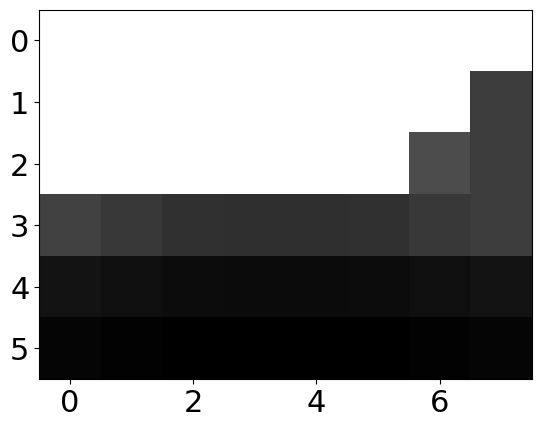

V118238_V118239_V118240 at step=12 t=12 d=0.1761176058568878 o=3.135759956299422


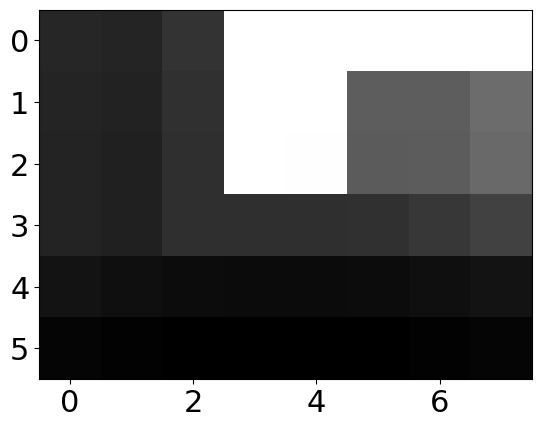

V118242_V118243_V118244 at step=13 t=13 d=0.1761176058568878 o=-0.005832703716996512


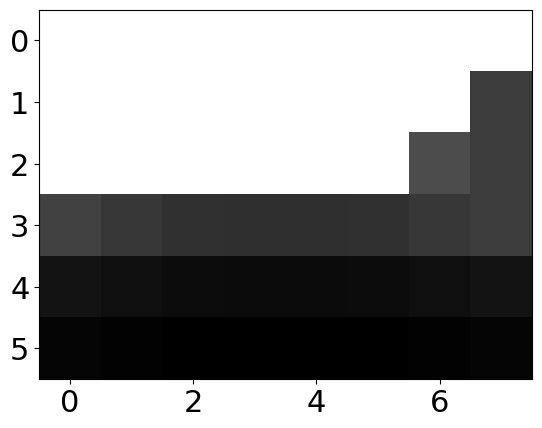

V118246_V118247_V118248 at step=14 t=14 d=0.1761176058568878 o=3.1367128622265588


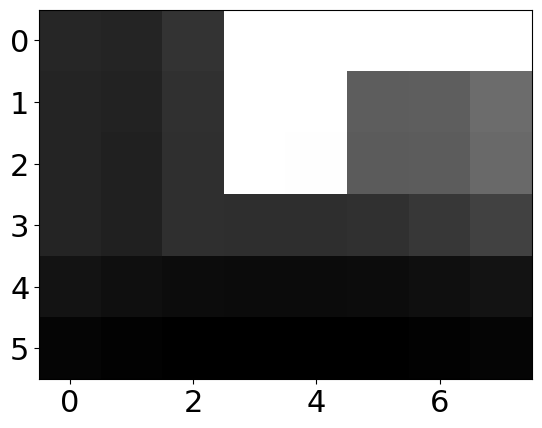

V118250_V118251_V118252 at step=15 t=15 d=0.1761176058568878 o=-0.004879725278801761


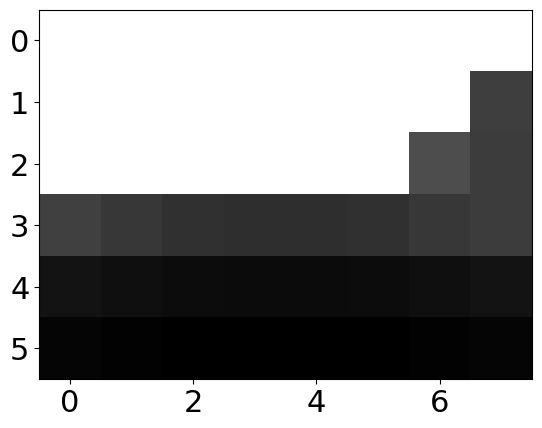

V118254_V118255_V118256 at step=16 t=16 d=0.1761176058568878 o=3.1377106934461017


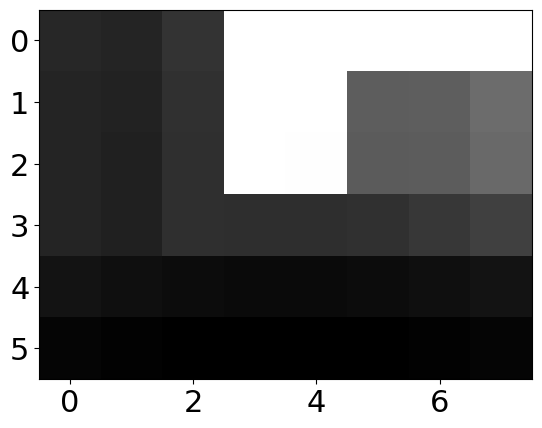

V118258_V118259_V118260 at step=17 t=17 d=0.1761176058568878 o=-0.0038819798261022775


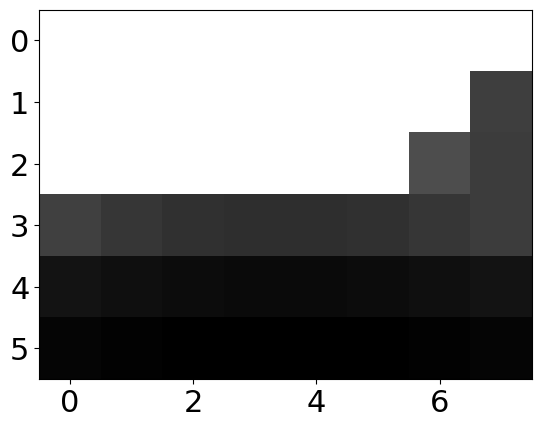

V118262_V118263_V118264 at step=18 t=18 d=0.1761176058568878 o=3.138753346702173


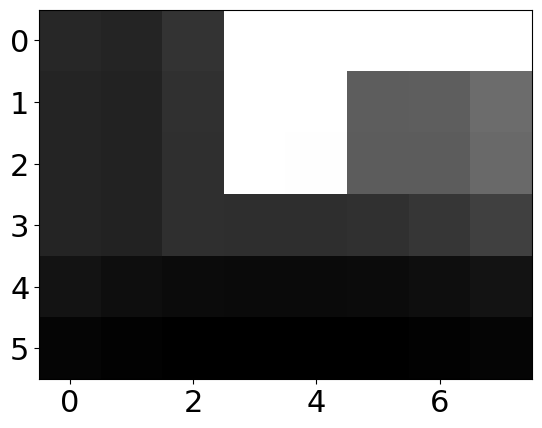

V118266_V118267_V118268 at step=19 t=19 d=0.1761176058568878 o=-0.0028393652368725597


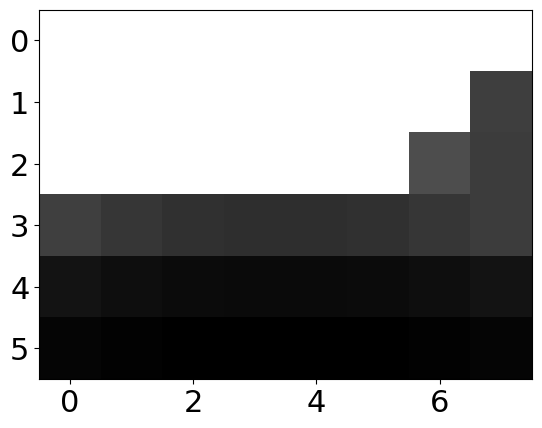

In [23]:
# view specific observations
# this example visualizes the last episode
nTimesteps = 1 # how many steps is set to look in past from config file
flattened_depth_size = [6,8]
min_d = 1e-2
max_d = 100
min_o = -1*math.pi
max_o = math.pi
min_output = 0.1
max_output = 1
obs_instances = [
    #train_path + 'train_states',
    test_path + 'states',
]
for instance in obs_instances:
    # read observations
    files = [file for file in os.listdir(instance) if 'observations' in file]
    observations = {}
    for file in files:
        observation_set = np.load(instance + '/' + file, allow_pickle=True)
        observations.update(observation_set)
    for set_num, episodes in enumerate(all_evaluations[instance][:1]):
        for episode, states in enumerate(episodes[:1]):
            for step, state in enumerate(states[1:]):
                observation_name = state['observation_name']
                observation = observations[observation_name]
                vLength = int(len(observation) / nTimesteps)
                for n in range(nTimesteps):
                    # if following the example py file on the github it has this strucutre 
                    # you may need to change how this is visualized if edited
                    time_observation = observation[vLength*n:vLength*n+vLength]
                    flattened_depth = np.interp(time_observation[:-2],
                                                (min_output, max_output),
                                                (min_d, max_d), )
                    goal_distance = np.interp(time_observation[-2],
                                                (min_output, max_output),
                                                (min_d, max_d), )
                    goal_orientation = np.interp(time_observation[-1],
                                                (min_output, max_output),
                                                (min_o, max_o), )
                    print(f'{observation_name} at step={step} t={step-n} d={goal_distance} o={goal_orientation}')
                    plt.imshow(flattened_depth.reshape(flattened_depth_size), cmap='gray')
                    plt.show()